---
### Imports & Setup

In [5]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis, shapiro
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import random
import sklearn.metrics.pairwise  as pairwise
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

random_seed = 51
random.seed(random_seed)
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [6]:
df_book_id = pd.read_csv("book_id_map.csv")
print("*" * 150 + "\ndf_book_id:")
display(df_book_id.head())
print("\nShape:", df_book_id.shape)
print("\nDTypes:")
display(df_book_id.dtypes)
print("\nBasic Stats:")
display(df_book_id.describe())

df_titles = pd.read_csv("book_titles.csv")
print("*" * 150 + "\ndf_titles:")
display(df_titles.head())
print("\nShape:", df_titles.shape)
print("\nDTypes:")
display(df_titles.dtypes)
print("\nBasic Stats:")
display(df_titles.describe())

df_collab = pd.read_csv("collaborative_books_df.csv", index_col=0)
print("*" * 150 + "\ndf_collab:")
display(df_collab.head())
print("\nShape:", df_collab.shape)
print("\nDTypes:")
display(df_collab.dtypes)
print("\nBasic Stats:")
display(df_collab.describe())


df_collab_meta = pd.read_csv("collaborative_book_metadata.csv", index_col=0)
print("*" * 150 + "\ndf_collab_meta:")
display(df_collab_meta.head())
print("\nShape:", df_collab_meta.shape)
print("\nDTypes:")
display(df_collab_meta.dtypes)
print("\nBasic Stats:")
display(df_collab_meta.describe())

df_user = pd.read_csv("user_id_map.csv", index_col=0)
print("*" * 150 + "\ndf_user:")
display(df_user.head())
print("\nShape:", df_user.shape)
print("\nDTypes:")
display(df_user.dtypes)
print("\nBasic Stats:")
display(df_user.describe())

******************************************************************************************************************************************************
df_book_id:


,book_id_csv,book_id
0,0,34684622
1,1,34536488
2,2,34017076
3,3,71730
4,4,30422361



Shape: (2360650, 2)

DTypes:


book_id_csv    int64
book_id        int64
dtype: object


Basic Stats:


,book_id_csv,book_id
count,2360650.00,2360650.00
mean,1180324.50,15409483.45
std,681461.10,10818936.32
min,0.00,1.00
25%,590162.25,5979042.75
50%,1180324.50,15856798.00
75%,1770486.75,24381907.25
max,2360649.00,36530431.00


******************************************************************************************************************************************************
df_titles:


,title,book_id
0,The Unschooled Wizard Sun Wolf and Starhawk 12,7327624
1,Best Friends Forever,6066819
2,The Aeneid for Boys and Girls,287141
3,Alls Fairy in Love and War Avalon Web of Magic 8,6066812
4,The Devils Notebook,287149



Shape: (1447341, 2)

DTypes:


title      object
book_id     int64
dtype: object


Basic Stats:


,book_id
count,1447341.00
mean,14301119.28
std,10378319.55
min,1.00
25%,4084497.00
50%,13634534.00
75%,22674297.00
max,36530431.00


******************************************************************************************************************************************************
df_collab:


,title,book_id,user_id_mapping,book_id_mapping,Predicted Rating,Actual Rating
0,I Am the Messenger,19057,1537,299,4.50,5
1,I Am the Messenger,19057,23039,299,4.90,3
2,I Am the Messenger,19057,39096,299,3.90,3
3,I Am the Messenger,19057,14631,299,4.70,4
4,I Am the Messenger,19057,32816,299,4.30,5



Shape: (196296, 6)

DTypes:


title                object
book_id               int64
user_id_mapping       int64
book_id_mapping       int64
Predicted Rating    float64
Actual Rating         int64
dtype: object


Basic Stats:


,book_id,user_id_mapping,book_id_mapping,Predicted Rating,Actual Rating
count,196296.00,196296.00,196296.00,196296.00,196296.00
mean,3473576.23,34493.95,383.59,3.90,3.92
std,5986357.93,21915.76,257.47,0.75,1.01
min,1.00,0.00,0.00,1.00,1.00
25%,9717.00,15608.75,157.00,3.40,3.00
50%,50398.00,32618.00,351.00,4.00,4.00
75%,6137154.00,51919.00,588.00,4.50,5.00
max,30555488.00,84564.00,917.00,5.00,5.00


******************************************************************************************************************************************************
df_collab_meta:


,book_id,title,image_url,url,num_pages,ratings_count,description,genre,name,book_id_mapping
0,5899779,Pride and Prejudice and Zombies Pride and Prej...,https://images.gr-assets.com/books/1320449653m...,https://www.goodreads.com/book/show/5899779-pr...,320,105537,The New York Times Best Seller is now a major ...,"['fantasy, paranormal', 'romance', 'fiction', ...",Jane Austen,808
1,872333,Blue Bloods Blue Bloods 1,https://images.gr-assets.com/books/1322281515m...,https://www.goodreads.com/book/show/872333.Blu...,302,117633,"When the Mayflower set sail in 1620, it carrie...","['young-adult', 'fantasy, paranormal', 'romanc...",Melissa de la Cruz,217
2,15507958,Me Before You Me Before You 1,https://images.gr-assets.com/books/1357108762m...,https://www.goodreads.com/book/show/15507958-m...,369,609327,Louisa Clark is an ordinary young woman living...,"['romance', 'fiction']",Jojo Moyes,385
3,66559,Sharp Objects,https://images.gr-assets.com/books/1423241485m...,https://www.goodreads.com/book/show/66559.Shar...,254,208394,"Fresh from a brief stay at a psych hospital, r...","['mystery, thriller, crime', 'fiction']",Gillian Flynn,192
4,7235533,The Way of Kings The Stormlight Archive 1,https://images.gr-assets.com/books/1507307887m...,https://www.goodreads.com/book/show/7235533-th...,1007,151473,"Speak again the ancient oaths,\nLife before de...","['fantasy, paranormal', 'fiction']",Brandon Sanderson,873



Shape: (96, 10)

DTypes:


book_id             int64
title              object
image_url          object
url                object
num_pages           int64
ratings_count       int64
description        object
genre              object
name               object
book_id_mapping     int64
dtype: object


Basic Stats:


,book_id,num_pages,ratings_count,book_id_mapping
count,96.00,96.00,96.00,96.00
mean,4877488.53,388.97,235801.39,477.64
std,7380797.30,431.42,190783.35,264.94
min,13.00,26.00,50020.00,19.00
25%,32967.50,242.25,115396.00,239.00
50%,269441.50,313.00,175739.50,473.50
75%,8865223.50,420.00,277544.25,712.25
max,29069989.00,4100.00,1128913.00,915.00


******************************************************************************************************************************************************
df_user:


,user_id
user_id_csv,
0,8842281e1d1347389f2ab93d60773d4d
1,72fb0d0087d28c832f15776b0d936598
2,ab2923b738ea3082f5f3efcbbfacb218
3,d986f354a045ffb91234e4af4d1b12fd
4,7504b2aee1ecb5b2872d3da381c6c91e



Shape: (876145, 1)

DTypes:


user_id    object
dtype: object


Basic Stats:


,user_id
count,876145
unique,876145
top,8842281e1d1347389f2ab93d60773d4d
freq,1


---
#### Data Quality Dimensions
In order to measure Data Quality in the multiple datasets, the following data quality dimensions will be considered:
1. **Completeness**: Data values are present;
    - Compute number of NaNs in each dataset, by column & row, total and percentages
    - Compute number of NaNs of the merged dataset, by column & row, total and percentages
    
2. **Consistency**:  Data satisfies constraints (format, allowable ranges and values, domain rules);
    - Evaluate Current Dtypes and Formats
    - Calculate the min, max, mean, and median values of numerical variables
    - Compute the value counts of categorical variables
    - Check the distribution, namely if it fits any distribution type and if it has excessive skewness and/or kurtosis; perform Shapiro-Wilk test
    - Compute Outliers

3. **Uniqueness**: Records representing a single customer are not replicated;
    - Look for repeat entries based on unique identifiers

Other data quality measures - **Timeliness**, **Correctness**, **Stability**, **Relevance**, **Contextualization** and **Trustworthiness** - are either irrelevant or unfeasible to test, so we will assume they have good quality and no measures will be computed for them.

---

#### Issues Found:

The implementation of the fixes to the problems below will be detailed along the code. Only minimal cleaning that allows us to perform EDA tasks will be done. Any specific cleaning required for model building (e..g normalization of scales) should be done in Feature Engeneering.

---

#### Metrics Used & Results Detailed Along Code
---
#### Further EDA:


---
##### 1. Completeness
 - description

In [7]:
# Compute number of NaNs in each dataset, by column & row, total and percentages
def nan_stats(df: pd.DataFrame, print_output: bool = True) -> list:
    """
    Computes NaN statisitcs of 'df'
    
    Parameters
    ---------------
    df: pd.DataFrame
        Pandas dataframe used to compute the NaN statistics
    print_output: bool
        Boolean value with default value True, that determines whether
        the computed NaN statistics are printed when function is called
 
    Returns
    ---------------
    l_nan_stats: list
        A list with the NaN statistics. First position [0] will have the
        sum by column, second position [1] the number of rows with at
        least one NaN, third position [2] the percentage of rows with at
        least one NaN, forth [3] the total number of NaNs and fith [4]
        the percentage of NaN values in the dataframe
    
    """
    var_name = [name for name, value in globals().items() if value is df][0]
    temp_shape = df.shape
    temp_sum_col = df.isna().sum()
    temp_sum_row = sum(df.isna().sum(axis=1) > 0)
    temp_percent_row = round(100 * temp_sum_row / temp_shape[0], 2)
    temp_sum_all = temp_sum_col.sum()
    temp_percent_all = round(
        100 * temp_sum_all / (temp_shape[0] * temp_shape[1]), 2
    )

    if print_output:
        print("\n" + "*" * 150, "\nNaNs in {}:".format(var_name))
        display(temp_sum_col)
        print("Total Rows with NaNs:", temp_sum_row)
        print("Percentage of Rows with NaNs", str(temp_percent_row) + "%")
        print("Total NaNs:", temp_sum_all)
        print("Percentage of NaNs", str(temp_percent_all) + "%")
        return None

    l_nan_stats = [
        temp_sum_col, temp_sum_row, temp_percent_row, temp_sum_all,
        temp_percent_all
    ]
    return l_nan_stats

nan_stats(df_book_id)
nan_stats(df_titles)
nan_stats(df_collab)
nan_stats(df_user)

"""	
n_completeness_old = nan_stats(df_merged, print_output=False)[3]
p_completeness_old = nan_stats(df_merged, print_output=False)[4]
"""


****************************************************************************************************************************************************** 
NaNs in df_book_id:


book_id_csv    0
book_id        0
dtype: int64

Total Rows with NaNs: 0
Percentage of Rows with NaNs 0.0%
Total NaNs: 0
Percentage of NaNs 0.0%

****************************************************************************************************************************************************** 
NaNs in df_titles:


title      9393
book_id       0
dtype: int64

Total Rows with NaNs: 9393
Percentage of Rows with NaNs 0.65%
Total NaNs: 9393
Percentage of NaNs 0.32%

****************************************************************************************************************************************************** 
NaNs in df_collab:


title               0
book_id             0
user_id_mapping     0
book_id_mapping     0
Predicted Rating    0
Actual Rating       0
dtype: int64

Total Rows with NaNs: 0
Percentage of Rows with NaNs 0.0%
Total NaNs: 0
Percentage of NaNs 0.0%

****************************************************************************************************************************************************** 
NaNs in df_user:


user_id    0
dtype: int64

Total Rows with NaNs: 0
Percentage of Rows with NaNs 0.0%
Total NaNs: 0
Percentage of NaNs 0.0%


'\t\nn_completeness_old = nan_stats(df_merged, print_output=False)[3]\np_completeness_old = nan_stats(df_merged, print_output=False)[4]\n'

In [8]:
# Check if the books with NaN titles are in the df_book_id dataframe
df_temp = df_titles[df_titles["title"].isna()]
display(df_temp.head())
display(df_temp[~df_temp["book_id"].isin(df_book_id["book_id"])])
display(df_temp[df_temp["book_id"].isin(df_collab["book_id"])])

del df_temp

,title,book_id
46,NaN,18283091
88,NaN,20971603
181,NaN,16111978
197,NaN,28820570
225,NaN,18711343


,title,book_id


,title,book_id


In [9]:
# Drop the rows with NaN titles, since there are no ratings for those books
df_titles.dropna(subset=["title"], inplace=True)

---
##### 2. Consistency
- Incorrect Dtypes/Format found: 
    - Change all book_id and book_id-mapping from integer to string.

- Inconsistencies in datetime variables found:
    - None.

- min, max, mean and median values of numerical variables:
    - No strange values.

- Value counts of categorical variables:
    - No strange values.
    
- Distribution & Outliers:
    - The data distributions shows us that we are exoected to predict more higher ratings than small ratings. However, the actual rating are a little smaller than those we predicted.
    - There are somo outliers in our data but most refere to number of pages. As it is normal to have some books with a lot of number pages, compared to most of the books seen in the market, we will keep this values.

In [10]:
# Evaluate current dtypes and formats
print("df_book_id:")
display(df_book_id.head())
print(df_book_id.dtypes)

print("\n" + "*" * 150 + "\ndf_titles:")
display(df_titles.head())
print(df_titles.dtypes)

print("\n" + "*" * 150 + "\ndf_collab:")
display(df_collab.head())
print(df_collab.dtypes)

print("\n" + "*" * 150 + "\ndf_collab_meta:")
display(df_collab_meta.head())
print(df_collab_meta.dtypes)

print("\n" + "*" * 150 + "\ndf_user:")
display(df_user.head())
print(df_user.dtypes)

def unique_types(df: pd.DataFrame, col: str) -> set:
    """
    Returns the unique dtypes in a Dataframe column
    
    Parameters
    ---------------
    df: pd.DataFrame
        Pandas dataframe with the column being evaluated
    col: str
        Name of the column evaluated
 
    Returns
    ---------------
    unique_types: set
        A set with the unique dtypes in the column
    
    """
    unique_types = {type(x) for x in df[col]}
    return unique_types

print("\n" + "*" * 150 + "\nUnique Types:\n")
print("title in df_titles:", unique_types(df_titles, "title"))
print("\ntitle in df_collab:", unique_types(df_collab, "title"))
print("\ntitle in df_collab_meta:", unique_types(df_collab_meta, "title"))
print("image_url in df_collab_meta:", unique_types(df_collab_meta, "image_url"))
print("url in df_collab_meta:", unique_types(df_collab_meta, "url"))
print("description in df_collab_meta:", unique_types(df_collab_meta, "description"))
print("genre in df_collab_meta:", unique_types(df_collab_meta, "genre"))
print("name in df_collab_meta:", unique_types(df_collab_meta, "name"))
print("\nuser_id in df_user:", unique_types(df_user, "user_id"))

df_book_id:


,book_id_csv,book_id
0,0,34684622
1,1,34536488
2,2,34017076
3,3,71730
4,4,30422361


book_id_csv    int64
book_id        int64
dtype: object

******************************************************************************************************************************************************
df_titles:


,title,book_id
0,The Unschooled Wizard Sun Wolf and Starhawk 12,7327624
1,Best Friends Forever,6066819
2,The Aeneid for Boys and Girls,287141
3,Alls Fairy in Love and War Avalon Web of Magic 8,6066812
4,The Devils Notebook,287149


title      object
book_id     int64
dtype: object

******************************************************************************************************************************************************
df_collab:


,title,book_id,user_id_mapping,book_id_mapping,Predicted Rating,Actual Rating
0,I Am the Messenger,19057,1537,299,4.50,5
1,I Am the Messenger,19057,23039,299,4.90,3
2,I Am the Messenger,19057,39096,299,3.90,3
3,I Am the Messenger,19057,14631,299,4.70,4
4,I Am the Messenger,19057,32816,299,4.30,5


title                object
book_id               int64
user_id_mapping       int64
book_id_mapping       int64
Predicted Rating    float64
Actual Rating         int64
dtype: object

******************************************************************************************************************************************************
df_collab_meta:


,book_id,title,image_url,url,num_pages,ratings_count,description,genre,name,book_id_mapping
0,5899779,Pride and Prejudice and Zombies Pride and Prej...,https://images.gr-assets.com/books/1320449653m...,https://www.goodreads.com/book/show/5899779-pr...,320,105537,The New York Times Best Seller is now a major ...,"['fantasy, paranormal', 'romance', 'fiction', ...",Jane Austen,808
1,872333,Blue Bloods Blue Bloods 1,https://images.gr-assets.com/books/1322281515m...,https://www.goodreads.com/book/show/872333.Blu...,302,117633,"When the Mayflower set sail in 1620, it carrie...","['young-adult', 'fantasy, paranormal', 'romanc...",Melissa de la Cruz,217
2,15507958,Me Before You Me Before You 1,https://images.gr-assets.com/books/1357108762m...,https://www.goodreads.com/book/show/15507958-m...,369,609327,Louisa Clark is an ordinary young woman living...,"['romance', 'fiction']",Jojo Moyes,385
3,66559,Sharp Objects,https://images.gr-assets.com/books/1423241485m...,https://www.goodreads.com/book/show/66559.Shar...,254,208394,"Fresh from a brief stay at a psych hospital, r...","['mystery, thriller, crime', 'fiction']",Gillian Flynn,192
4,7235533,The Way of Kings The Stormlight Archive 1,https://images.gr-assets.com/books/1507307887m...,https://www.goodreads.com/book/show/7235533-th...,1007,151473,"Speak again the ancient oaths,\nLife before de...","['fantasy, paranormal', 'fiction']",Brandon Sanderson,873


book_id             int64
title              object
image_url          object
url                object
num_pages           int64
ratings_count       int64
description        object
genre              object
name               object
book_id_mapping     int64
dtype: object

******************************************************************************************************************************************************
df_user:


,user_id
user_id_csv,
0,8842281e1d1347389f2ab93d60773d4d
1,72fb0d0087d28c832f15776b0d936598
2,ab2923b738ea3082f5f3efcbbfacb218
3,d986f354a045ffb91234e4af4d1b12fd
4,7504b2aee1ecb5b2872d3da381c6c91e


user_id    object
dtype: object

******************************************************************************************************************************************************
Unique Types:

title in df_titles: {<class 'str'>}

title in df_collab: {<class 'str'>}

title in df_collab_meta: {<class 'str'>}
image_url in df_collab_meta: {<class 'str'>}
url in df_collab_meta: {<class 'str'>}
description in df_collab_meta: {<class 'str'>}
genre in df_collab_meta: {<class 'str'>}
name in df_collab_meta: {<class 'str'>}

user_id in df_user: {<class 'str'>}


In [11]:
# Change the ids int64 to string
df_book_id["book_id_csv"] = df_book_id["book_id_csv"].astype(str)
df_book_id["book_id"] = df_book_id["book_id"].astype(str)

df_titles["book_id"] = df_titles["book_id"].astype(str)

df_collab["book_id"] = df_collab["book_id"].astype(str)
df_collab["user_id_mapping"] = df_collab["user_id_mapping"].astype(str)
df_collab["book_id_mapping"] = df_collab["book_id_mapping"].astype(str)

df_collab_meta["book_id"] = df_collab_meta["book_id"].astype(str)
df_collab_meta["book_id_mapping"] = df_collab_meta["book_id_mapping"].astype(str)

# Change the string in the genre column to a list
df_collab_meta["genre"] = df_collab_meta["genre"].str.replace("[", "").str\
                                            .replace("]" , "" ).str.split(",")

In [12]:
# Calculate the min, max, mean, and median values of numerical variables
print("*" * 150 + "\ndf_collab:")
display(df_collab[["Predicted Rating", "Actual Rating"]].describe())

print("*" * 150 + "\ndf_collab_meta:")
display(df_collab_meta[["num_pages", "ratings_count"]].describe())

******************************************************************************************************************************************************
df_collab:


,Predicted Rating,Actual Rating
count,196296.00,196296.00
mean,3.90,3.92
std,0.75,1.01
min,1.00,1.00
25%,3.40,3.00
50%,4.00,4.00
75%,4.50,5.00
max,5.00,5.00


******************************************************************************************************************************************************
df_collab_meta:


,num_pages,ratings_count
count,96.00,96.00
mean,388.97,235801.39
std,431.42,190783.35
min,26.00,50020.00
25%,242.25,115396.00
50%,313.00,175739.50
75%,420.00,277544.25
max,4100.00,1128913.00


******************************************************************************************************************************************************
df_collab:


book_id
2767052     1296
3           1195
41865       1092
6148028     1043
15881       1036
            ... 
18114322      63
7938275       61
23513349      59
4865          51
1430          36
Name: count, Length: 898, dtype: int64

book_id
2767052    0.01
3          0.01
41865      0.01
6148028    0.01
15881      0.01
           ... 
18114322   0.00
7938275    0.00
23513349   0.00
4865       0.00
1430       0.00
Name: proportion, Length: 898, dtype: float64

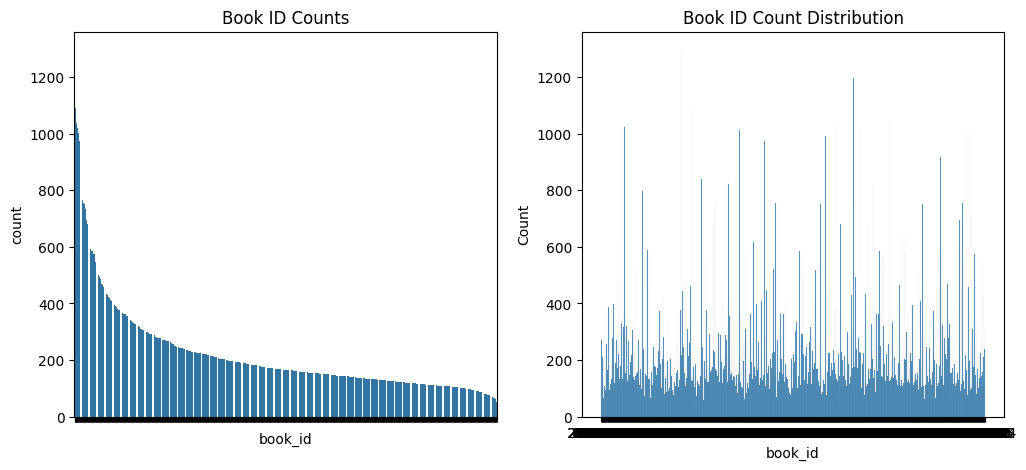

user_id_mapping
3716     22
9826     20
5224     19
2644     19
315      18
         ..
81        1
67061     1
78262     1
78536     1
70216     1
Name: count, Length: 66909, dtype: int64

user_id_mapping
3716    0.00
9826    0.00
5224    0.00
2644    0.00
315     0.00
        ... 
81      0.00
67061   0.00
78262   0.00
78536   0.00
70216   0.00
Name: proportion, Length: 66909, dtype: float64

******************************************************************************************************************************************************
df_collab_meta:


name
Christopher Paolini         3
Fiona Staples               3
Charlaine Harris            3
J.K. Rowling                2
Stephenie Meyer             2
Terry Pratchett             2
Stephen King                2
Colleen Hoover              2
George R.R. Martin          2
Robert Jordan               2
Tony Moore                  1
Joseph Heller               1
Philip Pullman              1
Melissa Marr                1
Karen Marie Moning          1
Jessica Sorensen            1
Ernest H. Shepard           1
Tom Clancy                  1
Maggie Stiefvater           1
Jhumpa Lahiri               1
Sarah Dessen                1
Richelle Mead               1
John Higgins                1
Joana Avillez               1
Emily Giffin                1
Jane Austen                 1
Dennis Lehane               1
Jenny Han                   1
Nell Scovell                1
Douglas Smith               1
Jeanne DuPrau               1
Mattias Ripa                1
Caitlin Moran               1
Art S

name
Christopher Paolini        0.03
Fiona Staples              0.03
Charlaine Harris           0.03
J.K. Rowling               0.02
Stephenie Meyer            0.02
Terry Pratchett            0.02
Stephen King               0.02
Colleen Hoover             0.02
George R.R. Martin         0.02
Robert Jordan              0.02
Tony Moore                 0.01
Joseph Heller              0.01
Philip Pullman             0.01
Melissa Marr               0.01
Karen Marie Moning         0.01
Jessica Sorensen           0.01
Ernest H. Shepard          0.01
Tom Clancy                 0.01
Maggie Stiefvater          0.01
Jhumpa Lahiri              0.01
Sarah Dessen               0.01
Richelle Mead              0.01
John Higgins               0.01
Joana Avillez              0.01
Emily Giffin               0.01
Jane Austen                0.01
Dennis Lehane              0.01
Jenny Han                  0.01
Nell Scovell               0.01
Douglas Smith              0.01
Jeanne DuPrau              0.01
Mat

In [13]:
# Compute the value counts of categorical variables
print("*" * 150 + "\ndf_collab:")
df_temp = df_collab["book_id"].value_counts()
display(df_collab["book_id"].value_counts())
display(df_collab["book_id"].value_counts(normalize=True))

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x="book_id", y="count", data=df_temp.reset_index(), ax=ax[0])
ax[0].set_title("Book ID Counts")
ax[0].set_xticklabels([])
sns.histplot(df_collab["book_id"], ax=ax[1])
ax[1].set_title('Book ID Count Distribution')
plt.show()

display(df_collab["user_id_mapping"].value_counts())
display(df_collab["user_id_mapping"].value_counts(normalize=True))

print("*" * 150 + "\ndf_collab_meta:")
display(df_collab_meta["name"].value_counts())
display(df_collab_meta["name"].value_counts(normalize=True))

del df_temp, fig, ax

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
df_collab:
******************************************************************************************************************************************************
Predicted Rating:


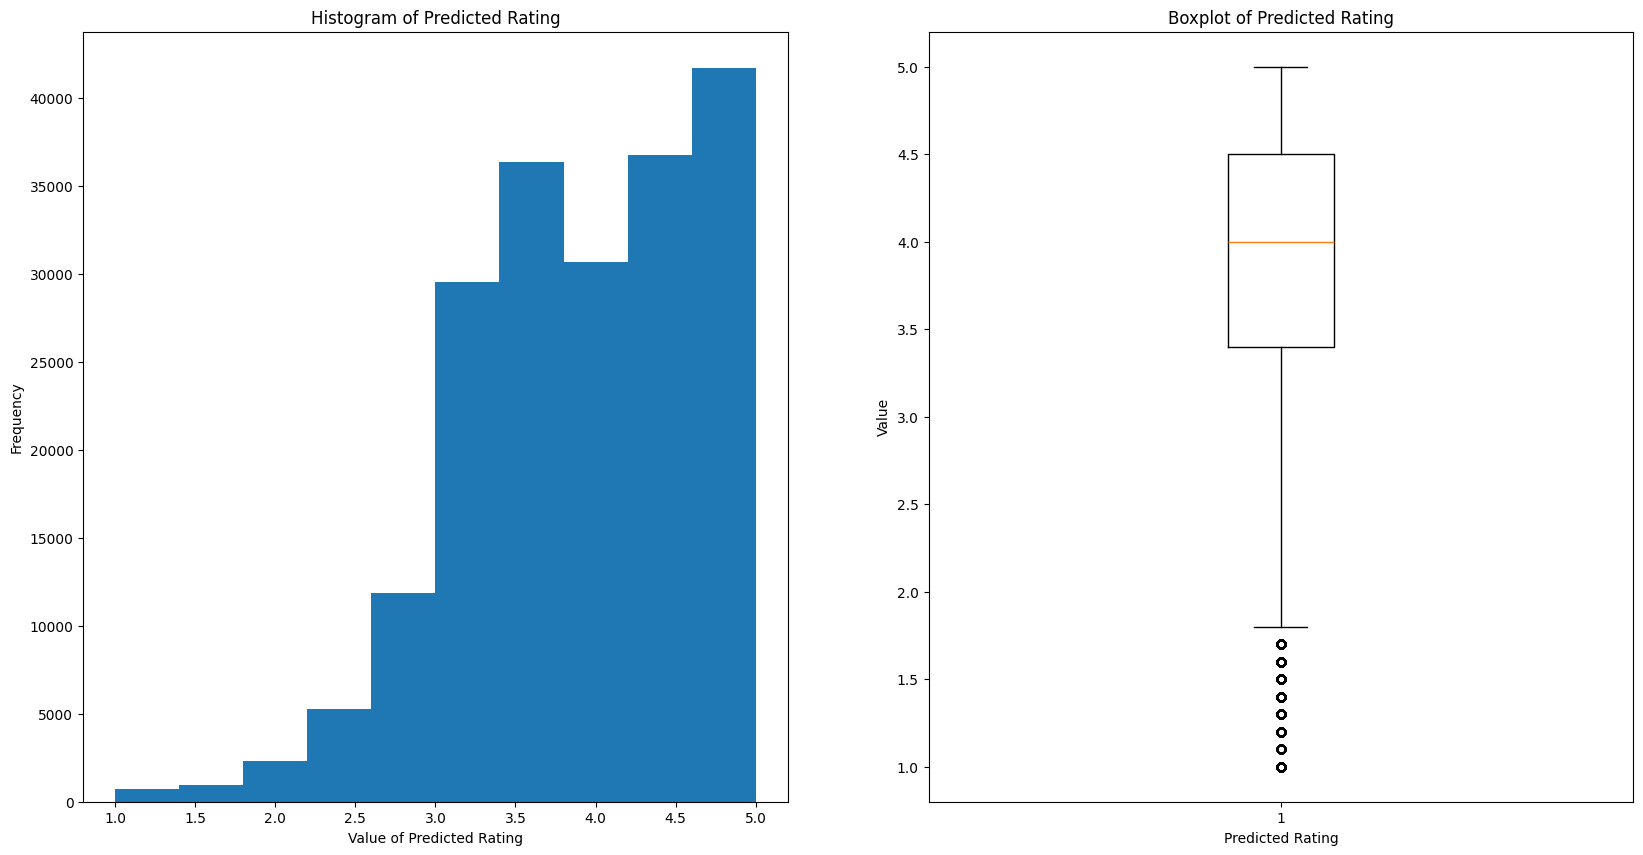

Number of Outliers: 1679
Percentage of Outliers 0.86%
Skewness: -0.6202161267467516
Kurtosis: 0.2987400715649642
Shapiro: 0.9639786810823551 | p_value: 2.1557114610856872e-98 

******************************************************************************************************************************************************
Actual Rating:


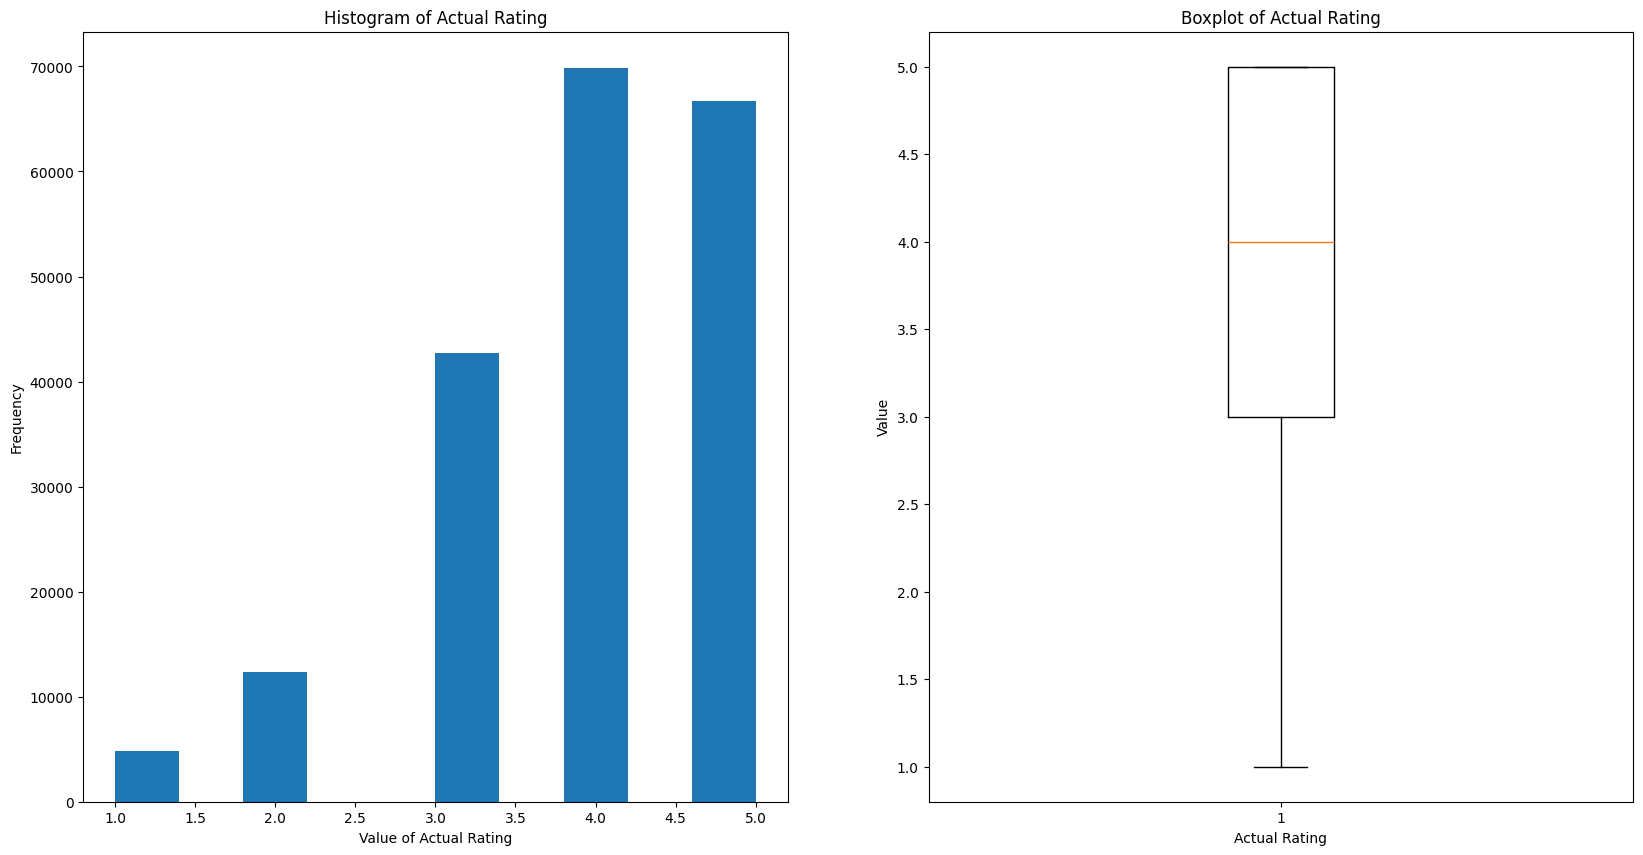

Number of Outliers: 0
Percentage of Outliers 0.0%
Skewness: -0.7796268347923789
Kurtosis: 0.1214450682098871
Shapiro: 0.8502807744721865 | p_value: 1.0723789049454796e-138 

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
df_collab_meta:
******************************************************************************************************************************************************
num_pages:


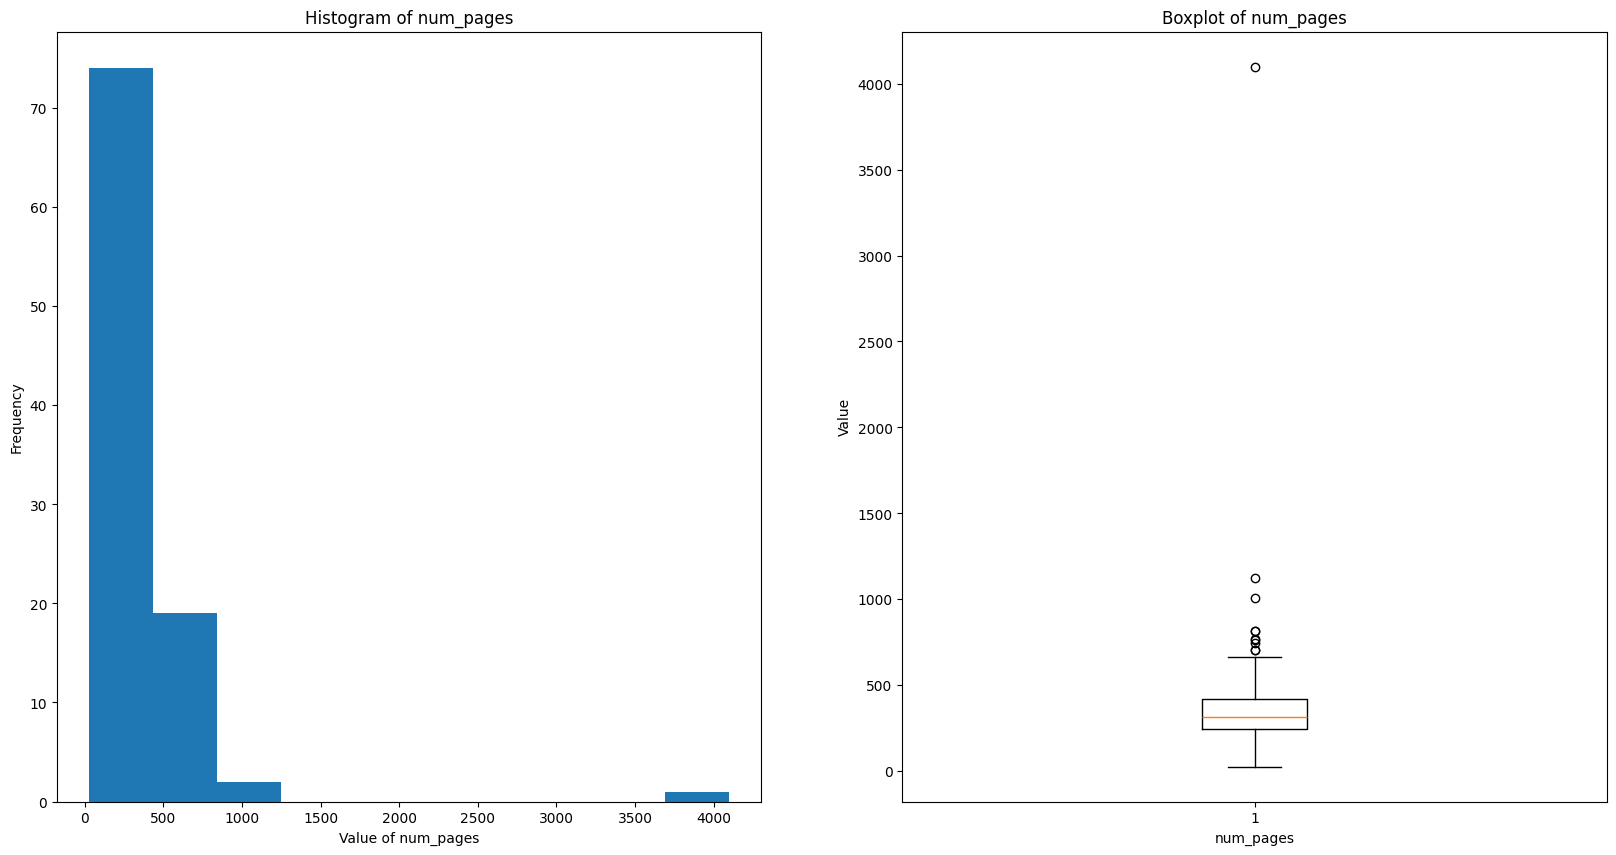

Number of Outliers: 10
Percentage of Outliers 10.42%
Skewness: 6.814550032758129
Kurtosis: 55.45458432784171
Shapiro: 0.4331451977961608 | p_value: 1.6238729938293723e-17 

******************************************************************************************************************************************************
ratings_count:


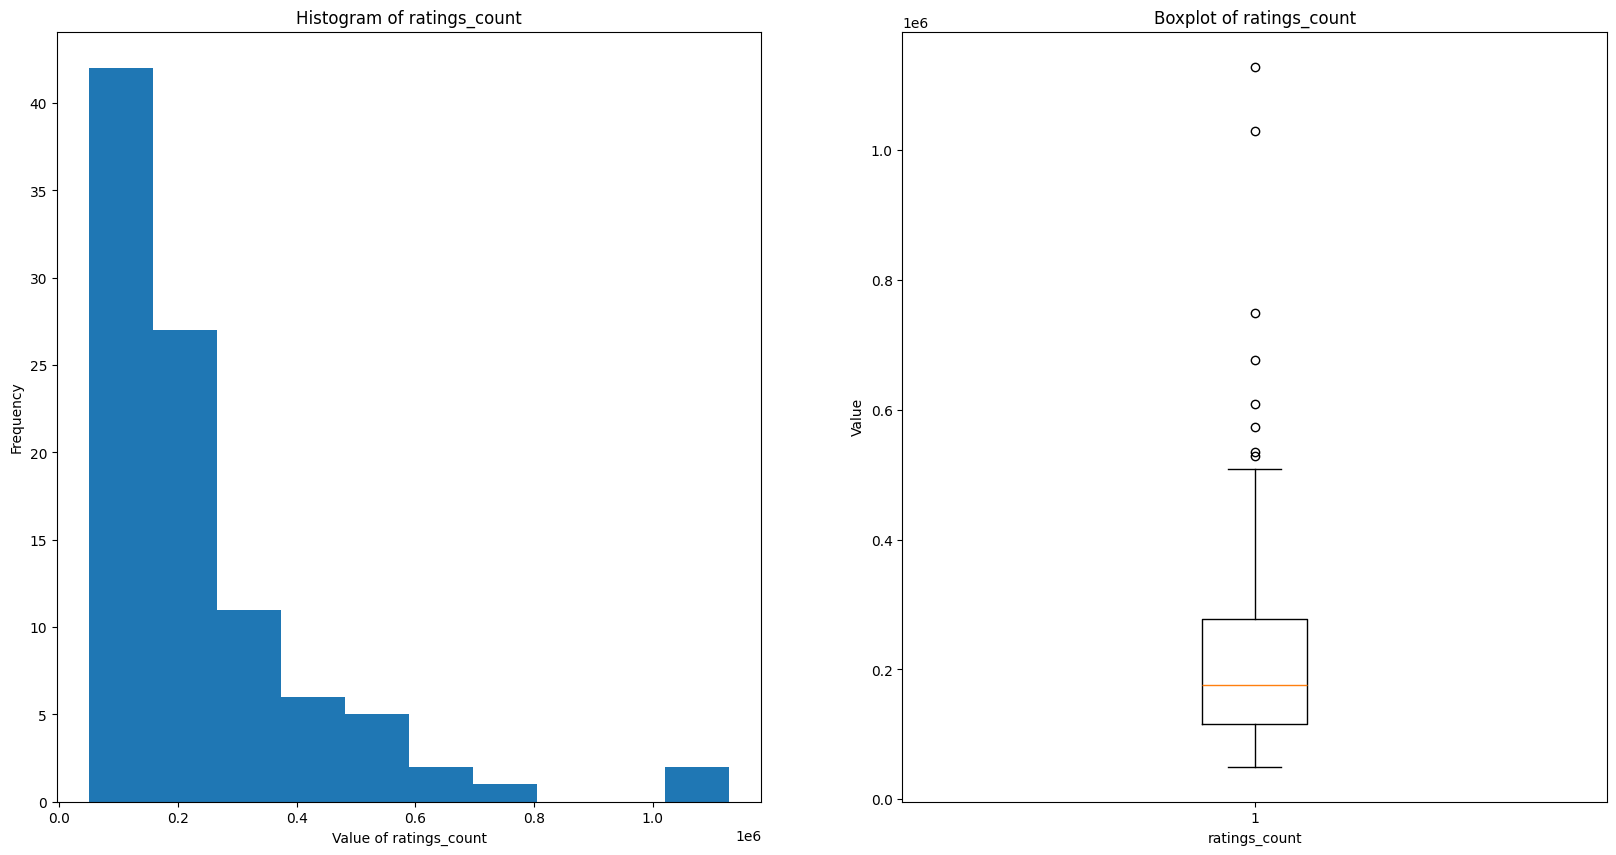

Number of Outliers: 8
Percentage of Outliers 8.33%
Skewness: 2.3591900578013467
Kurtosis: 6.789976184693014
Shapiro: 0.7543842984981813 | p_value: 2.257013091536787e-11 



In [14]:
# Check the distribution & Compute Outliers
def distribution(df_col : pd.Series, plot_distribution : bool = True) -> list:
       """
    Computes distribution statisitcs of 'df_col'
    
    Parameters
    ---------------
    df_col: pd.Series
        Pandas series used to compute the distribution statistics
    plot_distribution: bool
        Boolean value with default value True, that determines whether
        an histogram and boxplot are plotted and if the calculated stats
        are printed
 
    Returns
    ---------------
    l_dist_stats: list
        A list with the distribution statistics. First position [0] has
        number of outliers, second position [1] the percentage of 
        outliers, third position [2] the skewness, forth [3] the 
        kurtosis and fith [4] and sixth [5] the outcomes of the 
        Shapiro-Wilk test (W-stat and p-value)

       """
       # Number of outliers computed using 1.5 IQR range
       q1 = df_col.quantile(0.25)
       q3 = df_col.quantile(0.75)
       iqr = q3 - q1
       n_outliers = df_col[
              (df_col < (q1 - 1.5 * iqr)) | ((df_col > (q3 + 1.5 * iqr)))
       ].shape[0]
       per_outliers = n_outliers / df_col.shape[0]

       # Skewness, Kurtosis and Shapiro-Wilk test computed using 
       # scipy.stats library (ignoring nans)
       skewness = skew(df_col, nan_policy="omit")
       kurt = kurtosis(df_col, nan_policy="omit")
       shapiro_stat, p_value = shapiro(df_col.dropna())

       if plot_distribution:
              df_plot = df_col.dropna()
              fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

              # Histogram
              ax1.hist(df_plot)
              ax1.set_title(f"Histogram of {df_plot.name}")
              ax1.set_xlabel(f"Value of {df_plot.name}")
              ax1.set_ylabel(f"Frequency")

              #Boxplot
              ax2.boxplot(df_plot, vert=True)
              ax2.set_title(f"Boxplot of {df_plot.name}")
              ax2.set_xlabel(df_plot.name)
              ax2.set_ylabel(f"Value")
              
              plt.show()

              # Print stats
              print("Number of Outliers:", n_outliers)
              print("Percentage of Outliers", 
                    str(round(100 * per_outliers, 2)) + "%")
              print("Skewness:", skewness)
              print("Kurtosis:", kurt)
              print("Shapiro:", shapiro_stat, "| p_value:", p_value, "\n")
              return None
       
       l_dist_stats = [
              n_outliers, per_outliers, skewness, kurt, shapiro_stat, p_value
       ]
       return l_dist_stats


print("\\" * 150 + "\ndf_collab:")
print("*" * 150 + "\nPredicted Rating:")
distribution(df_collab["Predicted Rating"])
print("*" * 150 + "\nActual Rating:")
distribution(df_collab["Actual Rating"])

print("\\" * 150 + "\ndf_collab_meta:")
print("*" * 150 + "\nnum_pages:")
distribution(df_collab_meta["num_pages"])
print("*" * 150 + "\nratings_count:")
distribution(df_collab_meta["ratings_count"])

---
##### 3. Uniqueness
- There are no duplicates values in our dataset, whcih shows that our data is complete

In [15]:
# Look for repeat entries based on the book_id and user_id variables
def number_of_duplicates(df: pd.DataFrame, unique_id: list, print_output: bool = True) -> int:
       """
       Computes number of duplicates of 'df', based on unique identifiers
       in 'unique_id' 
    Parameters
    ---------------
    df: pd.DataFrame
        Pandas series used to compute the distribution statistics
    unique_id: list
        List with the unique identifiers used to determine duplicates. For a 
        single identifier, a list with a single element or a list can be passed
    print_output: bool
        Boolean value with default value True, that determines whether
        the number of duplicates will be printed in text output,
        in addition to an example of duplicate rows
 
    Returns
    ---------------
    n_duplicates: int
        Int value with the number of duplicate rows of 'df', based on
        the column INDIVIDUAL_ID
    """
       
       n_duplicates = df.duplicated(subset=unique_id).sum()
       p_duplicates = round(100 * n_duplicates / df.shape[0], 2)

       if print_output:
              var_name = [name for name, value in globals().items() if value is df][0]
              print("*" * 150, "\n" + var_name + ":" + " (" + ", ".join(unique_id) + ")")
              print("Number of Duplicates:", n_duplicates)
              print("Percentage of Duplicates:", str(p_duplicates) + "%")
              return None

       return n_duplicates, p_duplicates

number_of_duplicates(df_book_id, ["book_id"])
number_of_duplicates(df_titles, ["book_id"])
number_of_duplicates(df_collab, ["book_id", "user_id_mapping"])
number_of_duplicates(df_collab_meta, ["book_id"])
number_of_duplicates(df_user, ["user_id"])

****************************************************************************************************************************************************** 
df_book_id: (book_id)
Number of Duplicates: 0
Percentage of Duplicates: 0.0%
****************************************************************************************************************************************************** 
df_titles: (book_id)
Number of Duplicates: 0
Percentage of Duplicates: 0.0%
****************************************************************************************************************************************************** 
df_collab: (book_id, user_id_mapping)
Number of Duplicates: 0
Percentage of Duplicates: 0.0%
****************************************************************************************************************************************************** 
df_collab_meta: (book_id)
Number of Duplicates: 0
Percentage of Duplicates: 0.0%
*****************************************************************

---
#### Data Quality Metrics
Since there are no duplicates and NaNs, there is no need to compute the metrics for the dataset, as our treatment didn't affect its quality


---
#### Further EDA

user_id_mapping
0      4.14
1      3.80
10     4.50
100    3.50
1000   5.00
       ... 
9993   4.00
9995   4.75
9996   4.00
9997   3.50
9999   2.50
Length: 66909, dtype: float64

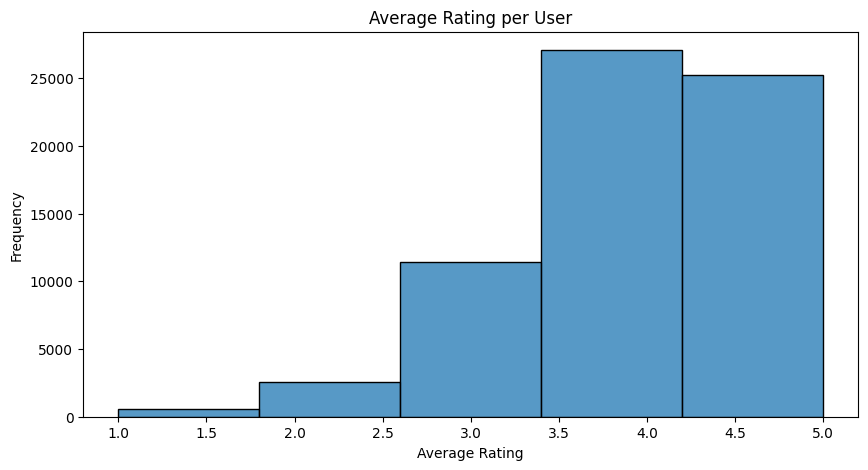

book_id_mapping
0     3.42
1     3.86
10    3.73
100   3.81
101   4.12
      ... 
95    3.88
96    4.01
97    4.31
98    3.46
99    3.31
Length: 898, dtype: float64

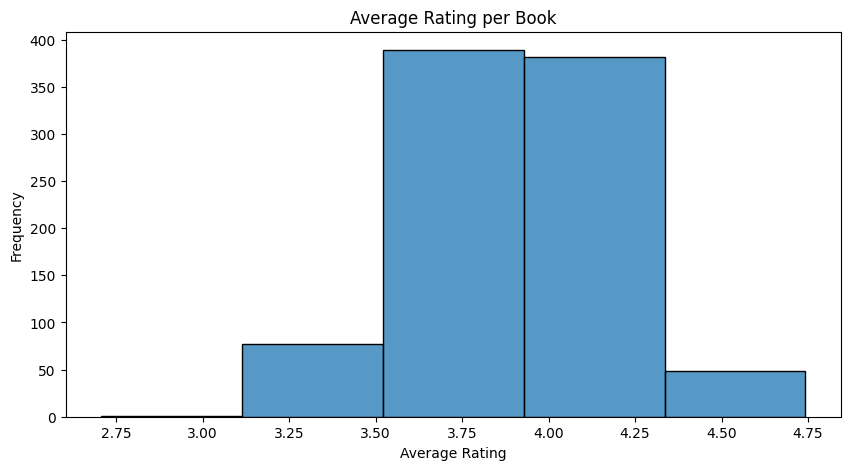

In [16]:
# Calculate the Average Rating of each user and book (out of existing ratings)
df_ratings_all = pd.pivot_table(
    data = df_collab,
    index = "user_id_mapping",
    columns = "book_id_mapping",
    values = "Actual Rating"
)
df_ratings_mean_user = df_ratings_all.mean(axis=1)
display(df_ratings_mean_user)
plt.figure(figsize=(10, 5))
sns.histplot(df_ratings_mean_user, bins=5)
plt.title("Average Rating per User")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.show()

df_ratings_mean_book = df_ratings_all.mean(axis=0)
display(df_ratings_mean_book)
plt.figure(figsize=(10, 5))
sns.histplot(df_ratings_mean_book, bins=5)
plt.title("Average Rating per Book")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.show()

user_id_mapping
0        7
1       10
10       2
100      2
1000     2
        ..
9993     1
9995     4
9996     2
9997     2
9999     4
Length: 66909, dtype: int64

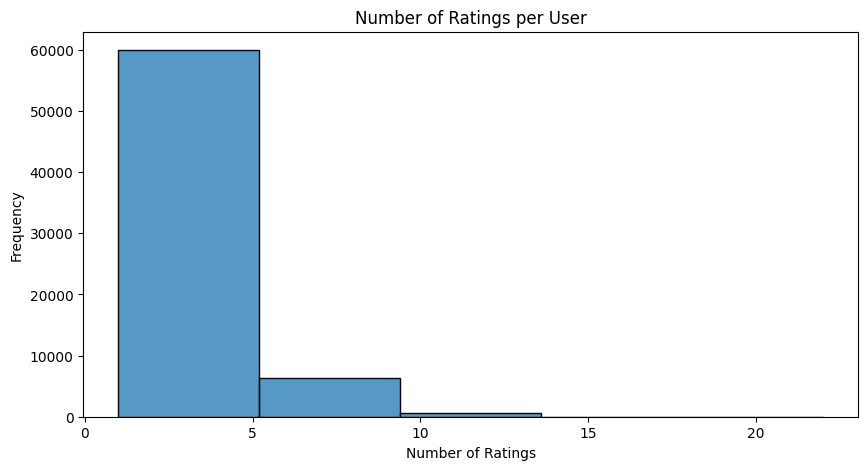

book_id_mapping
0      252
1      292
10     237
100    191
101    151
      ... 
95     463
96     109
97     154
98     826
99     374
Length: 898, dtype: int64

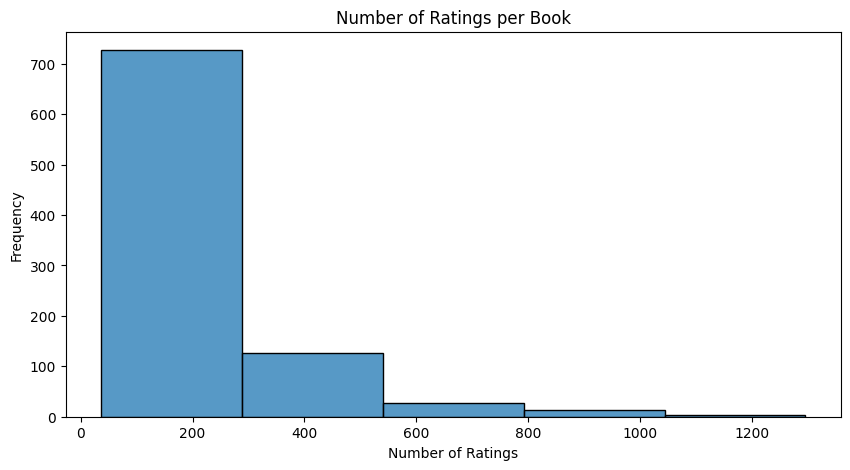

In [17]:
# Number of Reviews per user and book
df_ratings_count_user = df_ratings_all.count(axis=1)
display(df_ratings_count_user)
plt.figure(figsize=(10, 5))
sns.histplot(df_ratings_count_user, bins=5)
plt.title("Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

df_ratings_count_book = df_ratings_all.count(axis=0)
display(df_ratings_count_book)
plt.figure(figsize=(10, 5))
sns.histplot(df_ratings_count_book, bins=5)
plt.title("Number of Ratings per Book")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

In [18]:
# Quantile distributions of the counts
display(df_ratings_count_user.quantile([0.05, 0.1, 0.25, 0.5, 0.75, 0.9]))
display(df_ratings_count_book.quantile([0.05, 0.1, 0.25, 0.5, 0.75, 0.9]))

0.05   1.00
0.10   1.00
0.25   1.00
0.50   2.00
0.75   4.00
0.90   6.00
dtype: float64

0.05    92.00
0.10   104.00
0.25   125.00
0.50   165.50
0.75   243.00
0.90   386.30
dtype: float64

In [19]:
# Subset the data based on number of ratings to reduce sparsity and redo the analysis
df_ratings_subset = df_ratings_all.loc[
    df_ratings_count_user[df_ratings_count_user >= 4].index,
    df_ratings_count_book[df_ratings_count_book >= 100].index
]
display(df_ratings_subset)

book_id_mapping,0,1,10,100,101,102,103,104,105,106,...,914,917,92,93,94,95,96,97,98,99
user_id_mapping,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN
999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


user_id_mapping
0       4.14
1       3.89
10001   4.20
10002   2.50
10004   3.14
        ... 
9980    3.67
9986    3.43
999     4.17
9995    4.75
9999    4.00
Length: 20574, dtype: float64

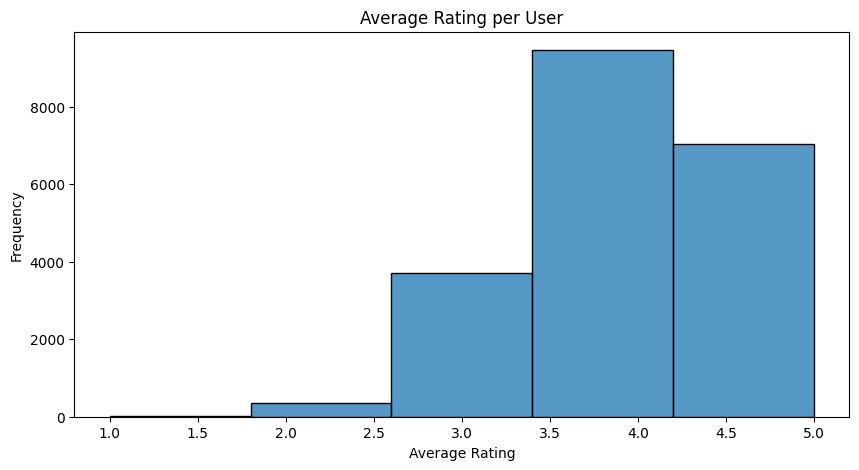

book_id_mapping
0     3.46
1     3.77
10    3.69
100   3.77
101   4.07
      ... 
95    3.92
96    4.08
97    4.30
98    3.35
99    3.31
Length: 829, dtype: float64

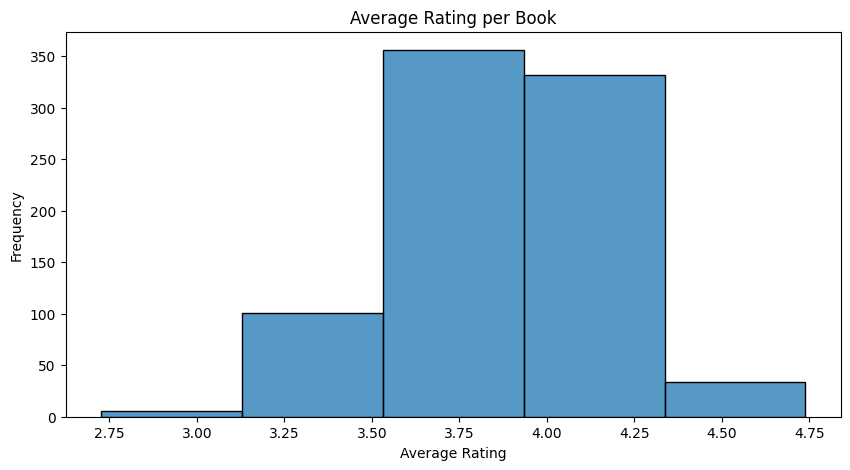

user_id_mapping
0        7
1        9
10001    5
10002    4
10004    7
        ..
9980     9
9986     7
999      6
9995     4
9999     1
Length: 20574, dtype: int64

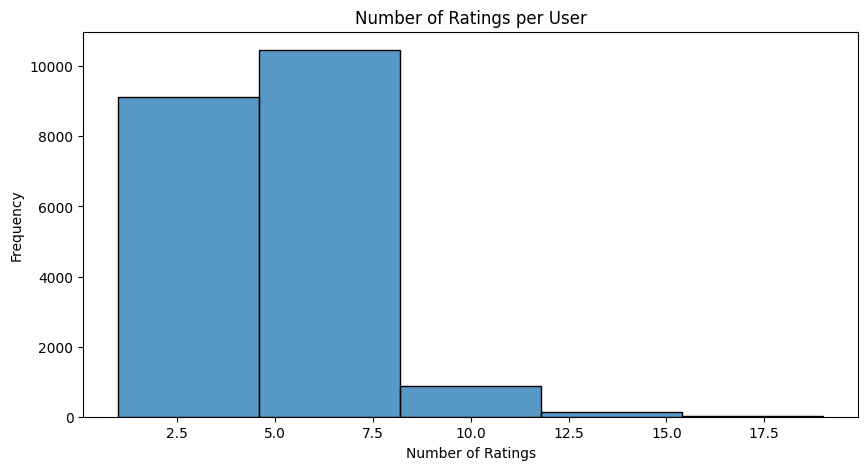

book_id_mapping
0      151
1      158
10     134
100    115
101     46
      ... 
95     262
96      53
97      88
98     440
99     226
Length: 829, dtype: int64

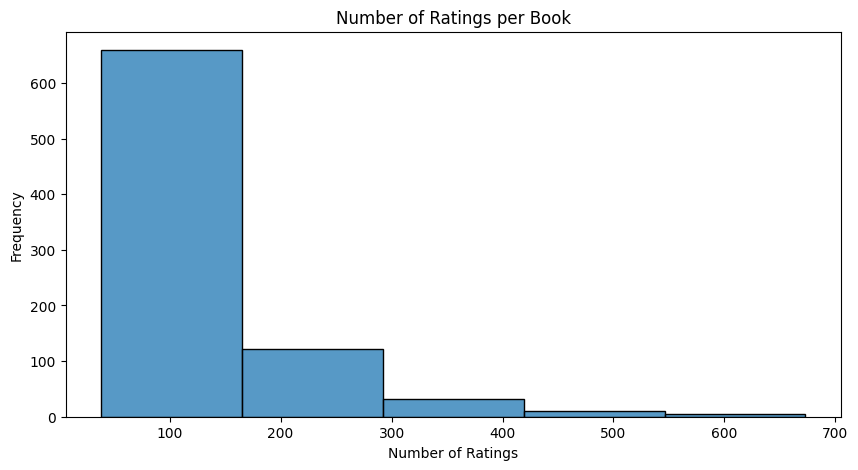

In [20]:
# Calculate the Average Rating of each user and book (out of existing ratings)
df_ratings_mean_user_subset = df_ratings_subset.mean(axis=1)
display(df_ratings_mean_user_subset)
plt.figure(figsize=(10, 5))
sns.histplot(df_ratings_mean_user_subset, bins=5)
plt.title("Average Rating per User")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.show()

df_ratings_mean_book_subset = df_ratings_subset.mean(axis=0)
display(df_ratings_mean_book_subset)
plt.figure(figsize=(10, 5))
sns.histplot(df_ratings_mean_book_subset, bins=5)
plt.title("Average Rating per Book")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.show()

# Number of Reviews per user and book
df_ratings_count_user_subset = df_ratings_subset.count(axis=1)
display(df_ratings_count_user_subset)
plt.figure(figsize=(10, 5))
sns.histplot(df_ratings_count_user_subset, bins=5)
plt.title("Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

df_ratings_count_book_subset = df_ratings_subset.count(axis=0)
display(df_ratings_count_book_subset)
plt.figure(figsize=(10, 5))
sns.histplot(df_ratings_count_book_subset, bins=5)
plt.title("Number of Ratings per Book")
plt.xlabel("Number of Ratings")
plt.ylabel("Frequency")
plt.show()

del df_ratings_all, df_ratings_mean_user, df_ratings_mean_book, df_ratings_count_user, df_ratings_count_book,\
    df_ratings_mean_user_subset, df_ratings_mean_book_subset, df_ratings_count_user_subset, df_ratings_count_book_subset

---
#### Preliminary Steps for Model Building
 - Train and Test Split: 70% Train and 30% Test, ensuring that all users and books in test are also in train to avoid cold starting issues

 - Merging data: Connect the title_id, book_id and the book_id_csv (equivalent to book_id_mapping)

 - Subsetting data: To train models differently and compare results, create a denser dataset where more users and books have more in common. Subsetting is done based on the results of the Further EDA section, so that only books with more than 100 reviews and only users with more than 3 reviews remain
 
 - Create Evaluation Metrics: We will evaluate the ranking components of our models, more specifically, if any of the models top recomendations are then reviewed in the test dataset (which simulates a customer buying the recommended book). We will use Precision to assess if our models are giving bad recommendations and Recall to assess if our models are missing out on relevant recommendations. 

The goal of the train-test split is to ensure that the model is not trained on the same data it will be tested on, to avoid overfitting. One thing to note, is that our split is done with shuffling, so the order of the data is not preserved. This choice was made because the reviews did not have any time information, but if the data had a time component, a different approach where the train data set would have older reviews and the test newer ones would be more appropriate.
 
The step that ensures that all users and books in the test data set are in the train did not remove any rows from the test, but on the other hand, the subset for users with more than 3 reviews and books with more than 100 reviews greatly reduced the size of the dataset. This is a good thing, since the goal is the experiment with different pre-processing and quantify the impact of the data set sparsity in our results. 

In [22]:
#Create the dataframe to evaluate that is 70% of the df_collab dataframe
df_sample = df_collab.groupby('user_id_mapping').apply(lambda x: x.sample(frac=0.7, random_state=random_seed))

#Get the test data set that is the other 30% 
df_test = df_collab.drop(df_sample.index.get_level_values(1))

df_sample.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

display(df_sample.head(), df_sample.shape)
display(df_test.head(), df_test.shape)

,title,book_id,user_id_mapping,book_id_mapping,Predicted Rating,Actual Rating
0,Things Fall Apart The African Trilogy 1,37781,0,872,4.10,4
1,A Child Called It Dave Pelzer 1,60748,0,847,2.80,3
2,The Hobbit,5907,0,162,3.30,4
3,The Girl with All the Gifts,17235026,1,88,3.90,4
4,The Great Gatsby,4671,1,290,4.10,3


(72234, 6)

,title,book_id,user_id_mapping,book_id_mapping,Predicted Rating,Actual Rating
0,A Child Called It Dave Pelzer 1,60748,6445,847,4.40,4
1,The Kite Runner,77203,17751,710,4.00,4
2,Love in the Time of Cholera,9712,11022,702,2.60,4
3,The Restaurant at the End of the Universe Hitc...,8695,15682,302,4.00,4
4,The Secret Life of Bees,37435,7507,588,3.60,3


(27766, 6)

In [23]:
# Merge the book_id_map to the titles dataframe as a preliminary step
df_titles = df_titles.merge(df_book_id.reset_index(), on="book_id", how="left")
df_titles["book_id_csv"] = df_titles["book_id_csv"].astype(str)
display(df_titles.head())

,title,book_id,index,book_id_csv
0,The Unschooled Wizard Sun Wolf and Starhawk 12,7327624,740362.00,740362
1,Best Friends Forever,6066819,14854.00,14854
2,The Aeneid for Boys and Girls,287141,839335.00,839335
3,Alls Fairy in Love and War Avalon Web of Magic 8,6066812,399574.00,399574
4,The Devils Notebook,287149,150331.00,150331


In [24]:
# Subset the data set to reduce sparsity
df_temp_all = pd.pivot_table(
    data = df_sample,
    index = "user_id_mapping",
    columns = "book_id_mapping",
    values = "Actual Rating"
)
df_temp_count_user = df_temp_all.count(axis=1)
df_temp_count_book = df_temp_all.count(axis=0)

df_sample_subset = df_sample.loc[
    df_sample["user_id_mapping"].isin(df_temp_count_user[df_temp_count_user >= 3].index) &
    df_sample["book_id"].isin(df_temp_count_book[df_temp_count_book >= 100].index)
]
display(df_sample_subset.head(), df_sample_subset.shape)

del df_temp_all, df_temp_count_user, df_temp_count_book

,title,book_id,user_id_mapping,book_id_mapping,Predicted Rating,Actual Rating
14,Anna Karenina,152,1001,747,2.90,5
79,Harry Potter and the HalfBlood Prince Harry Po...,1,10076,150,4.30,5
246,Harry Potter and the HalfBlood Prince Harry Po...,1,10205,150,4.40,4
602,Harry Potter and the Goblet of Fire Harry Pott...,6,10486,75,4.50,5
793,The Fellowship of the Ring The Lord of the Rin...,34,10638,243,3.40,3


(319, 6)

In [25]:
# Ensure that the test data set has the same users and books, to avoid cold start problem
df_test_clean_subset = df_test.loc[df_test["user_id_mapping"].isin(df_sample_subset["user_id_mapping"]) &
                                   df_test["book_id_mapping"].isin(df_sample_subset["book_id_mapping"])]
df_test_clean = df_test.loc[df_test["user_id_mapping"].isin(df_sample["user_id_mapping"]) &
                            df_test["book_id_mapping"].isin(df_sample["book_id_mapping"])]

display(df_test_clean.head(), df_test_clean.shape)
display(df_test_clean_subset.head(), df_test_clean_subset.shape)

,title,book_id,user_id_mapping,book_id_mapping,Predicted Rating,Actual Rating
0,A Child Called It Dave Pelzer 1,60748,6445,847,4.40,4
1,The Kite Runner,77203,17751,710,4.00,4
2,Love in the Time of Cholera,9712,11022,702,2.60,4
3,The Restaurant at the End of the Universe Hitc...,8695,15682,302,4.00,4
4,The Secret Life of Bees,37435,7507,588,3.60,3


(27766, 6)

,title,book_id,user_id_mapping,book_id_mapping,Predicted Rating,Actual Rating
2717,The Ultimate Hitchhikers Guide to the Galaxy,13,49441,230,5.00,4
2784,Harry Potter and the HalfBlood Prince Harry Po...,1,26887,150,4.10,4
2895,A Short History of Nearly Everything,21,43882,187,4.10,5
3477,The Fellowship of the Ring The Lord of the Rin...,34,31357,243,4.70,3
3805,Harry Potter and the HalfBlood Prince Harry Po...,1,61934,150,5.00,5


(13, 6)

In [26]:
# Evaluation Metrics
def evaluate_models(test_set, model, interaction_matrix, similarity_matrix, n=10):
    all_precision = []
    all_recall = []
    all_f1 = []

    users = test_set["user_id_mapping"].unique()
    if len(users) > 200:
        users = random.sample(list(users), 10000)
    
    df_interaction_matrix_test = pd.pivot_table(
    data = test_set,
    index = "user_id_mapping",
    columns = "book_id_mapping",
    values = "Actual Rating",
    )
    for user in users:
        actual_ratings = df_interaction_matrix_test.loc[user].dropna().sort_values(ascending = False)
        if len(actual_ratings) < 3:
            continue
        actual_ratings = actual_ratings.to_frame().merge(df_titles[["title", "book_id_csv"]], how = 'left', left_on = 'book_id_mapping', right_on = 'book_id_csv')
        actual_ratings = actual_ratings.rename(columns = {0: 'Actual Rating'}).drop(columns = 'book_id_csv')
        predicted_ratings = model(user, interaction_matrix, similarity_matrix, len(actual_ratings))

        result = predicted_ratings.head(n).copy()
        result["Correct Prediction"] = result["title"].isin(actual_ratings["title"])

        precision = result["Correct Prediction"].sum() / n
        recall = result["Correct Prediction"].sum() / len(actual_ratings)
        f1 = 2 * precision * recall / (precision + recall)

        all_precision.append(precision)
        all_recall.append(recall)
        if precision + recall == 0:
            all_f1.append(0)
            
    return [np.mean(all_precision), np.mean(all_recall), np.mean(all_f1)]

In [27]:
df_evaluations = pd.DataFrame(columns = ["Model", "Precision", "Recall", "F1"])

---
#### First Recommendation System: Content Based Filtering, using Title

In this approach, we will use the title of the books as a proxy for content. The idea behind Content Based Filtering is to recommend items to a user based if they are similar in content to the items the user has liked in the past. For example, if a user gave a high rating to a book titled "Introduction to Machine Learning", the system will likely recommend other books with similar titles, such as "Machine Learning for Dummies" or "Intermediate Machine Learning".

We are able to compute cosine similarity between titles, after vectorizing the text. The vectorization will be done using the TfidfVectorizer, which will convert the text into a matrix of TF-IDF features (TF-IDF features represent the weight of certain words within the text, which allows to reduce bias towards common words and longer titles). To get more accurate similarity measures, before vectorization we will also clean the title's text from stopwords and numerical values, which are not relevant to assert content similarity. 
The cosine similarity will be computed using the cosine_similarity function from sklearn.metrics.pairwise.

Unlike the other models we will test, which will have to deal with sparsity due the low number of books each user rates, this model is able to establish good comparisons between the books. Still, we must acknowledge that the quality of the recommendations of any content based approach, will depend on the quality of the data we have. So, just like we can have obvious similarities between "Introduction to Machine Learning" and "Machine Learning for Dummies", we can also have misleading similarities between "Introduction to Machine Learning" and "Introduction to Cooking". This initial iteration of our model can still lead to good insights, but this approach can be improved by extending the dataset with more content related features, such as the number of pages, the author, the liretary genre, etc.

In [28]:
#We are going to clean the titles to delete numbers and common words so that the model gets more reliable 

#Create a nre dataframe with unique movies 
df_title_train = df_sample["title"].unique()
df_title_train = pd.DataFrame(df_title_train, columns=["title"])
df_title_train["title_clean"] = df_title_train["title"]

#function to clean the titles
def clean_title(title):
    # List of words to be replaced
    words_to_replace = ['the', 'and', 'or', 'a', 'an', 'to', 'any', 'some', 'of', 'in', 'on', 'for', 'with', 'by', 'at', 'from', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    
    # Regular expression pattern to match whole words exactly
    regex_pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, words_to_replace)) + r')\b', re.IGNORECASE)
    title = regex_pattern.sub('', title)
    
    title = re.sub(r'\d+', '', title)

    
    return ' '.join(title.split())  



# Apply the clean_title function to the 'title' column
df_title_train['title_clean'] = df_title_train['title_clean'].apply(clean_title)

display(df_title_train.head())


,title,title_clean
0,Things Fall Apart The African Trilogy 1,Things Fall Apart African Trilogy
1,A Child Called It Dave Pelzer 1,Child Called It Dave Pelzer
2,The Hobbit,Hobbit
3,The Girl with All the Gifts,Girl All Gifts
4,The Great Gatsby,Great Gatsby


In [29]:
# Create a TfidfVectorizer and Remove stopwords
tfidf = TfidfVectorizer(stop_words='english') 
tfidf_matrix = tfidf.fit_transform(df_title_train['title_clean'])

# Create a dataframe with the similirarity score between titles 
content_cosign = pd.DataFrame(pairwise.cosine_similarity(tfidf_matrix, tfidf_matrix),
                              index=df_title_train['title'], 
                              columns=df_title_train['title'])
display(content_cosign.head())

title,Things Fall Apart The African Trilogy 1,A Child Called It Dave Pelzer 1,The Hobbit,The Girl with All the Gifts,The Great Gatsby,The Ultimate Hitchhikers Guide to the Galaxy,A Streetcar Named Desire,Twelfth Night,Lord of the Flies,Twilight Twilight 1,...,Losing It Losing It 1,Reflected in You Crossfire 2,The Secret The Secret 1,Hyperion Hyperion Cantos 1,Lean In Women Work and the Will to Lead,Mans Search for Meaning,Pretty Little Liars Pretty Little Liars 1,Hamlet Screenplay Introduction And Film Diary,Inheritance The Inheritance Cycle 4,The Trial
title,,,,,,,,,,,,,,,,,,,,,
Things Fall Apart The African Trilogy 1,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
A Child Called It Dave Pelzer 1,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
The Hobbit,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
The Girl with All the Gifts,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
The Great Gatsby,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [30]:
#Create a functon that for a specific book title returns the top 10 books with the higher similarity score
def get_recomendation_content(book):
    book_index = content_cosign.index.get_loc(book)
    top_10 = content_cosign.iloc[book_index].sort_values(ascending=False)[1:11]
    top_10 =  pd.DataFrame(top_10[top_10 != 0]).reset_index()
    top_10.rename(columns={book: 'score'}, inplace=True)
    return top_10

In [31]:
get_recomendation_content("Maus I A Survivors Tale My Father Bleeds History Maus 1")

,title,score
0,The Secret History,0.21
1,A Tale of Two Cities,0.19
2,The Thirteenth Tale,0.19
3,The Handmaids Tale,0.19
4,A Brief History of Time,0.17
5,A Short History of Nearly Everything,0.15
6,The Tale of Peter Rabbit,0.15
7,World War Z An Oral History of the Zombie War,0.10


In [32]:
#For a sprcific user it sees all the books the person has read in the past
#For each book a person read in the past we get the top 10 recommendation
#Join all the recommendations and delete the books the user has read in the past 
#Sum the scores of the books that were recomendated more than once 
#Return the top 10
def get_recomendation_content_user(user, interaction_matrix, similarity_matrix, n=10):
    df = df_sample[df_sample["user_id_mapping"]==user]
    rec = None
    for i in df["title"]:
        rec_i = get_recomendation_content(i)
        rec = pd.concat([rec, rec_i])
    rec = rec[~rec['title'].isin(df['title'])]  #apagar os livros que a pessoa já leu 
    rec = rec.groupby("title")["score"].sum()   #somar as pontuações de dois livros iguais 
    rec = rec.reset_index()
    rec = rec.sort_values("score", ascending = False)
    rec = rec.head(n)
    rec.rename(columns={"score": "Actual Rating"}, inplace=True)
    return rec

In [33]:
get_recomendation_content_user("319", None, None , 10)

,title,Actual Rating
0,Awakened House of Night 8,0.52
1,Betrayed House of Night 2,0.50
2,Burned House of Night 7,0.50
3,Chosen House of Night 3,0.50
4,Hunted House of Night 5,0.50
8,Tempted House of Night 6,0.50
9,Untamed House of Night 4,0.50
7,Night The Night Trilogy 1,0.43
6,Little House on the Prairie Little House 2,0.32
5,Little House in the Big Woods Little House 1,0.30


In [34]:
df_evaluations.loc[len(df_evaluations)] = ["Content Based"] + evaluate_models(df_test_clean, get_recomendation_content_user, None, None, 10)

In [35]:
#This function serves to evaluate how many books from the recommendation the user has read (from the test dataframe)
def evaluate(user):
    test_df_user = df_test[df_test["user_id_mapping"]==user]
    recomendations =  get_recomendation_content_user(user, None, None , None)
    common_titles_count = test_df_user['title'].isin(recomendations['title']).sum()
    return common_titles_count

In [36]:
evaluate("1537")

0

In [37]:
#Evaluate for several users 
user = df_collab["user_id_mapping"].unique()
random_users = random.sample(list(user), 10)
total_compra = 0
total_acertado = 0
for i in random_users:
    total_acertado += evaluate(i)
    total_compra += len(df_test[df_test["user_id_mapping"]==i])
print(total_acertado)
print(total_compra)

0
7


---
#### Second Recommendation System: Item Based Collaborative Filtering

Collaborative Filtering is one of the most popular and widely used recommender systems. It is based on the idea that users who agreed in the past will agree in the future. In other words, this method makes automatic predictions (filtering) about the interests of a user by collecting preferences from many users (collaborating). Even though it is a very simple algorithm, it is very powerful and has been used in many successful recommendation systems.

We will start off by implementing an item based approach, in which we will look for similarities between books, based on the ratings given by the users. In principle, if a user likes one book, then it is likely that it will like a similar book, or on the other hand, if a user dislikes one book, than similar books should not be recommended. Similarity can be interpreted as any kind of relationship between the ratings different customers give, but to think in a more practical way, we can say that two books are similar if users are consistent in their ratings of them.

We will experiment with different similarity metrics, namely cosine similarity, euclidean distance and pearson's coefficient. We expect cosign similarity to be the better measure, as it ignores the magnitude of the vectors and only considers the direction, so it correctly identifies similar books in cases where one customer gives two books an high rating and another customer gives the same two books a low rating. Still, we will experiment with other measures, as they can serve as Baselines for the cosign similarity models.

Euclidean distance measures a straight line between the two points in the space, with low distances indicating similarity (we do the inverse of the euclidian distance to normalize the result between 0 and 1). This creates a simple and interpretable measure, but it is still vulnerable to  great dimensionality of the vectors (this will be more pronounced in the user based CF, but still a relevant limitation). Also, it is vulnerable to missing values in the interaction matrix. Pearson's coefficient is a measure of the linear correlation between two variables, which would also capture cases when one user rates all books higher than another user. But since we are dealing with sparse data, this measure is not the most appropriate, as it is sensitive to the lack of ratings.

Finally, as observed in the EDA, the dataset is very sparse, even in the context of collaborative filtering systems. So, as we described in the preliminary steps section, we will also test the same models on the subsetted data, to understand the impact of the sparsity in the results.

Note: We used [this](https://dataaspirant.com/five-most-popular-similarity-measures-implementation-in-python/) resource linked in the slides to understand the different similarity measures.

In [84]:
# Create the user-item interaction matrix
df_interaction_matrix = pd.pivot_table(
    data = df_sample,
    index = "user_id_mapping",
    columns = "book_id_mapping",
    values = "Actual Rating",
    fill_value = 0
)
display(df_interaction_matrix.head(), df_interaction_matrix.shape)

df_interaction_matrix_subset = pd.pivot_table(
    data = df_sample_subset,
    index = "user_id_mapping",
    columns = "book_id_mapping",
    values = "Actual Rating",
    fill_value = 0
)
display(df_interaction_matrix_subset.head(), df_interaction_matrix_subset.shape)

book_id_mapping,0,1,10,100,101,102,103,104,105,106,...,916,917,92,93,94,95,96,97,98,99
user_id_mapping,,,,,,,,,,,,,,,,,,,,,
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10002,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


(52051, 898)

book_id_mapping,150,187,230,243,304,319,327,747,75
user_id_mapping,,,,,,,,,
1001,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00
10076,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10205,4.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10486,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00
10638,0.00,0.00,0.00,3.00,0.00,0.00,0.00,0.00,0.00


(312, 9)

In [39]:
# Compute the Cosine Similarity between items (using the transposed interaction matrix)
item_cosign_all = pd.DataFrame(pairwise.cosine_similarity(df_interaction_matrix.T),
                                  index = df_interaction_matrix.columns,
                                  columns = df_interaction_matrix.columns
                                  )
display(item_cosign_all.head())

book_id_mapping,0,1,10,100,101,102,103,104,105,106,...,916,917,92,93,94,95,96,97,98,99
book_id_mapping,,,,,,,,,,,,,,,,,,,,,
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00
10,0.00,0.01,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
100,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
101,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [40]:
item_cosign_subset = pd.DataFrame(pairwise.cosine_similarity(df_interaction_matrix_subset.T),
                                         index = df_interaction_matrix_subset.columns,
                                         columns = df_interaction_matrix_subset.columns
                                         )
display(item_cosign_subset.head())

book_id_mapping,150,187,230,243,304,319,327,747,75
book_id_mapping,,,,,,,,,
150,1.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.01
187,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
230,0.00,0.00,1.00,0.05,0.00,0.00,0.00,0.00,0.00
243,0.00,0.00,0.05,1.00,0.00,0.00,0.00,0.00,0.00
304,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.02


In [41]:
item_euclidean_all = pd.DataFrame(pairwise.euclidean_distances(df_interaction_matrix.T),
                                  index = df_interaction_matrix.columns,
                                  columns = df_interaction_matrix.columns                       
                                  )
item_euclidean_all = 1 / (1 + item_euclidean_all)
display(item_euclidean_all.head())

book_id_mapping,0,1,10,100,101,102,103,104,105,106,...,916,917,92,93,94,95,96,97,98,99
book_id_mapping,,,,,,,,,,,,,,,,,,,,,
0,1.00,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.02,0.02,...,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.02
1,0.02,1.00,0.02,0.02,0.02,0.02,0.02,0.01,0.02,0.02,...,0.02,0.02,0.01,0.01,0.02,0.01,0.02,0.02,0.01,0.02
10,0.02,0.02,1.00,0.02,0.02,0.02,0.02,0.01,0.02,0.02,...,0.02,0.02,0.02,0.01,0.02,0.02,0.02,0.02,0.01,0.02
100,0.02,0.02,0.02,1.00,0.02,0.02,0.02,0.01,0.02,0.02,...,0.03,0.02,0.02,0.01,0.02,0.02,0.02,0.02,0.01,0.02
101,0.02,0.02,0.02,0.02,1.00,0.02,0.02,0.01,0.02,0.02,...,0.03,0.02,0.02,0.01,0.02,0.02,0.02,0.02,0.01,0.02


In [85]:
item_euclidean_subset = pd.DataFrame(pairwise.euclidean_distances(df_interaction_matrix_subset.T),
                                     index = df_interaction_matrix_subset.columns,
                                     columns = df_interaction_matrix_subset.columns
                                     )
item_euclidean_subset = 1 / (1 + item_euclidean_subset)
display(item_euclidean_subset.head())

book_id_mapping,150,187,230,243,304,319,327,747,75
book_id_mapping,,,,,,,,,
150,1.00,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
187,0.02,1.00,0.05,0.03,0.05,0.06,0.05,0.05,0.02
230,0.02,0.05,1.00,0.03,0.04,0.05,0.04,0.04,0.02
243,0.02,0.03,0.03,1.00,0.03,0.03,0.03,0.03,0.02
304,0.02,0.05,0.04,0.03,1.00,0.05,0.04,0.05,0.02


In [43]:
item_pearson_all = df_interaction_matrix.corr()
display(item_pearson_all.head())

book_id_mapping,0,1,10,100,101,102,103,104,105,106,...,916,917,92,93,94,95,96,97,98,99
book_id_mapping,,,,,,,,,,,,,,,,,,,,,
0,1.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
1,-0.00,1.00,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.00,-0.00,-0.00,0.01,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
10,-0.00,0.01,1.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
100,-0.00,-0.00,-0.00,1.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.01
101,-0.00,-0.00,-0.00,-0.00,1.00,-0.00,-0.00,-0.00,-0.00,-0.00,...,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00


In [86]:
item_person_subset = df_interaction_matrix_subset.corr()
display(item_person_subset.head())

book_id_mapping,150,187,230,243,304,319,327,747,75
book_id_mapping,,,,,,,,,
150,1.00,-0.09,-0.13,-0.31,-0.13,-0.13,-0.13,-0.13,-0.34
187,-0.09,1.00,-0.03,-0.07,-0.03,-0.03,-0.04,-0.03,-0.09
230,-0.13,-0.03,1.00,-0.05,-0.04,-0.04,-0.05,-0.04,-0.12
243,-0.31,-0.07,-0.05,1.00,-0.11,-0.11,-0.13,-0.11,-0.30
304,-0.13,-0.03,-0.04,-0.11,1.00,-0.04,-0.05,-0.04,-0.10


In [45]:
# Create a function to get the top N recommendations
def get_recommendation_cf_item(user_id: str, interaction_matrix: pd.DataFrame, similarity_matrix: pd.DataFrame, n: int=10) -> pd.DataFrame:
    """
    Create predicted ratings, as the weighted sum of ratings given to similar 
    items, and get the top N predicted ratings. Since the goal is to recommend
    new books, books already rated by the user are excluded from the 
    recommendations.
    
    Parameters
    ---------------
    user_id: str
        User for which the recommendations are made
    df_interaction_matrix: pd.DataFrame
        Matrix with the user-item interactions
    similarity_matrix: pd.DataFrame
        Matrix with the similarity scores between items
    n: int
        Number of recommendations items to return, default value set to 10
 
    Returns
    ---------------
    top_n: pd.DataFrame
        Dataframe with the top N recommendations for a given user
        
    """
    user_ratings = interaction_matrix.loc[user_id]
    similar_scores = similarity_matrix[user_ratings.index]
    pred_ratings = similar_scores.dot(user_ratings) / similar_scores.sum()

    top_n = pred_ratings.to_frame().rename(columns={0: "Predicted Rating"})
    top_n = top_n[~top_n.index.isin(user_ratings[user_ratings > 0].index)]
    top_n = top_n.merge(df_titles[["title", "book_id_csv"]], left_index=True, right_on="book_id_csv")
    
    top_n.set_index("title", inplace=True)
    top_n.drop(columns=["book_id_csv"], inplace=True)
    top_n = top_n.sort_values("Predicted Rating", ascending=False).head(n).reset_index()
    
    
    return top_n[top_n["Predicted Rating"] > 0]

In [46]:
display(get_recommendation_cf_item("319", df_interaction_matrix, item_cosign_all, 10))

df_evaluations.loc[len(df_evaluations)] = ["CF Item Cosign All"] + evaluate_models(df_test_clean, get_recommendation_cf_item, df_interaction_matrix, item_cosign_all, 15)
display(df_evaluations)

,title,Predicted Rating
0,Moneyball The Art of Winning an Unfair Game,0.02
1,The Elegant Universe Superstrings Hidden Dimen...,0.02
2,Neuromancer Sprawl 1,0.01
3,The Murder on the Links Hercule Poirot 2,0.01
4,Manhattan Beach,0.01
5,Ancillary Justice Imperial Radch 1,0.01
6,The Manuscript Found in Saragossa,0.01
7,Pleased but not Satisfied,0.01
8,Design Patterns Elements of Reusable ObjectOri...,0.01
9,An Actor Prepares,0.01


,Model,Precision,Recall,F1
0,Content Based,0.00,0.00,0.00
1,CF Item Cosign All,0.00,0.00,0.00


In [53]:
get_recommendation_cf_item("10076", df_interaction_matrix_subset, item_cosign_subset, 10)

df_evaluations.loc[len(df_evaluations)] = ["CF Item Cosign Subset"] + evaluate_models(df_test_clean_subset, get_recommendation_cf_item, df_interaction_matrix_subset, item_cosign_subset, 15)
display(df_evaluations)

,Model,Precision,Recall,F1
0,Content Based,0.00,0.00,0.00
1,CF Item Cosign All,0.00,0.00,0.00
2,CF Item Cosign Subset,NaN,NaN,NaN
3,CF Item Cosign Subset,NaN,NaN,NaN


In [54]:
get_recommendation_cf_item("319", df_interaction_matrix, item_euclidean_all, 10)

df_evaluations.loc[len(df_evaluations)] = ["CF Item Euclidean All"] + evaluate_models(df_test_clean, get_recommendation_cf_item, df_interaction_matrix, item_euclidean_all, 15)
display(df_evaluations)

,Model,Precision,Recall,F1
0,Content Based,0.00,0.00,0.00
1,CF Item Cosign All,0.00,0.00,0.00
2,CF Item Cosign Subset,NaN,NaN,NaN
3,CF Item Cosign Subset,NaN,NaN,NaN
4,CF Item Euclidean All,0.00,0.00,0.00


In [55]:
get_recommendation_cf_item("10076", df_interaction_matrix_subset, item_euclidean_subset, 10)

df_evaluations.loc[len(df_evaluations)] = ["CF Item Euclidean Subset"] + evaluate_models(df_test_clean_subset, get_recommendation_cf_item, df_interaction_matrix_subset, item_euclidean_subset, 15)
display(df_evaluations)

,Model,Precision,Recall,F1
0,Content Based,0.00,0.00,0.00
1,CF Item Cosign All,0.00,0.00,0.00
2,CF Item Cosign Subset,NaN,NaN,NaN
3,CF Item Cosign Subset,NaN,NaN,NaN
4,CF Item Euclidean All,0.00,0.00,0.00
5,CF Item Euclidean Subset,NaN,NaN,NaN


In [56]:
get_recommendation_cf_item("319", df_interaction_matrix, item_pearson_all, 10)

df_evaluations.loc[len(df_evaluations)] = ["CF Item Pearson All"] + evaluate_models(df_test_clean, get_recommendation_cf_item, df_interaction_matrix, item_pearson_all, 15)
display(df_evaluations)

,Model,Precision,Recall,F1
0,Content Based,0.00,0.00,0.00
1,CF Item Cosign All,0.00,0.00,0.00
2,CF Item Cosign Subset,NaN,NaN,NaN
3,CF Item Cosign Subset,NaN,NaN,NaN
4,CF Item Euclidean All,0.00,0.00,0.00
5,CF Item Euclidean Subset,NaN,NaN,NaN
6,CF Item Pearson All,0.01,0.03,0.00


In [57]:
get_recommendation_cf_item("10076", df_interaction_matrix_subset, item_person_subset, 10)

df_evaluations.loc[len(df_evaluations)] = ["CF Item Pearson Subset"] + evaluate_models(df_test_clean_subset, get_recommendation_cf_item, df_interaction_matrix_subset, item_person_subset, 15)
display(df_evaluations)

,Model,Precision,Recall,F1
0,Content Based,0.00,0.00,0.00
1,CF Item Cosign All,0.00,0.00,0.00
2,CF Item Cosign Subset,NaN,NaN,NaN
3,CF Item Cosign Subset,NaN,NaN,NaN
4,CF Item Euclidean All,0.00,0.00,0.00
5,CF Item Euclidean Subset,NaN,NaN,NaN
6,CF Item Pearson All,0.01,0.03,0.00
7,CF Item Pearson Subset,NaN,NaN,NaN


#### Results & Limitations

---
#### Third Recommendation System: User Based Collaborative Filtering

Continuing with the Collaborative Filtering approach, we will now implement a user based model. In this model, we will look for similarities between users, based on the ratings they give to the books. The idea is that if two users have similar tastes, then they will rate books in a similar way. One advantage of the item-based approach that we implemented before, is that it is more likely to produce relevant recommendations, since the overlap of user ratings between books is more likely than the overlap of book ratings between users, because users only rate a few books, while books are rated by many users. So, we can expect sparsity to be an ever bigger issue in this model.

This was evident in the Further EDA section of the notebook, where the distribution of the number of ratings per book ranged from arround 50 to 1200 ratings, with most books located in the 50 to 300 range, while the distribution of the number of ratings per user ranged from 1 to 20 ratings, with most users having less than 5 ratings.

Additionally, items are usually less frequently newly introduced than users, so the cold start problem is also less prevalent. But still, an user based approach can be useful, as it builds richer user profiles and is more compatible with the real-world diversity of interests, while the item-based potentially separates users into stricly separate categories, which is more relevant for more objective industries, such as buying eletronics or gardening supplies.

We will experiment with Neighbors-based approach, where we look for the k users that are more similar to the input user, and then based on the similarity values and the ratings of the neighbors, we predict scores and create ranks. Like in the previous approach, we will also experiment with cosine similarity, euclidean distance and Pearson's coefficient, with the expectation that cosine performs better.

In [ ]:
# Compute the Cosign Similarity between users
user_cosign_all = pd.DataFrame(pairwise.cosine_similarity(df_interaction_matrix),
                                index=df_interaction_matrix.index,
                                columns=df_interaction_matrix.index
                                )
display(user_cosign_all.head())

In [87]:
user_cosign_subset = pd.DataFrame(pairwise.cosine_similarity(df_interaction_matrix_subset),
                                  index = df_interaction_matrix_subset.index,
                                  columns = df_interaction_matrix_subset.index
                                  )
display(user_cosign_subset.head())

user_id_mapping,1001,10076,10205,10486,10638,10683,10710,10771,11028,11066,...,9098,918,9212,9337,94,9413,9471,9754,9837,9910
user_id_mapping,,,,,,,,,,,,,,,,,,,,,
1001,1.00,0.00,0.00,0.00,0.00,0.00,0.71,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
10076,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10205,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10486,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,...,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
10638,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [ ]:
user_euclidean_all = pd.DataFrame(pairwise.euclidean_distances(df_interaction_matrix),
                                  index = df_interaction_matrix.index,
                                  columns = df_interaction_matrix.index
                                  )
user_euclidean_all = 1 / (1 + user_euclidean_all)
display(user_euclidean_all.head())

In [88]:
user_euclidean_subset = pd.DataFrame(pairwise.euclidean_distances(df_interaction_matrix_subset),
                                    index = df_interaction_matrix_subset.index,
                                    columns = df_interaction_matrix_subset.index
                                    )
user_euclidean_subset = 1 / (1 + user_euclidean_subset)
display(user_euclidean_subset.head())

user_id_mapping,1001,10076,10205,10486,10638,10683,10710,10771,11028,11066,...,9098,918,9212,9337,94,9413,9471,9754,9837,9910
user_id_mapping,,,,,,,,,,,,,,,,,,,,,
1001,1.00,0.12,0.14,0.12,0.15,0.14,0.17,0.15,0.14,0.16,...,0.12,0.12,0.12,0.14,0.12,0.12,0.14,0.12,0.33,0.14
10076,0.12,1.00,0.50,0.12,0.15,0.14,0.10,0.15,0.14,0.16,...,0.12,1.00,1.00,0.14,0.12,0.12,0.14,0.12,0.15,0.14
10205,0.14,0.50,1.00,0.14,0.17,0.15,0.11,0.17,0.15,0.18,...,0.14,0.50,0.50,0.15,0.14,0.14,0.15,0.14,0.17,0.15
10486,0.12,0.12,0.14,1.00,0.15,0.14,0.10,0.33,0.50,0.16,...,1.00,0.12,0.12,0.14,0.12,1.00,0.14,1.00,0.15,0.14
10638,0.15,0.15,0.17,0.15,1.00,0.50,0.12,0.19,0.17,0.22,...,0.15,0.15,0.15,0.17,0.15,0.15,0.17,0.15,0.19,0.50


In [ ]:
user_pearson_all = df_interaction_matrix.T.corr()
display(user_pearson_all.head())

In [89]:
user_pearson_subset = df_interaction_matrix_subset.T.corr()
display(user_pearson_subset.head())

user_id_mapping,1001,10076,10205,10486,10638,10683,10710,10771,11028,11066,...,9098,918,9212,9337,94,9413,9471,9754,9837,9910
user_id_mapping,,,,,,,,,,,,,,,,,,,,,
1001,1.00,-0.12,-0.13,-0.12,-0.12,-0.13,0.66,-0.12,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.13,-0.12,-0.12,-0.13,-0.12,1.00,-0.13
10076,-0.12,1.00,1.00,-0.12,-0.12,-0.12,-0.19,-0.12,-0.12,-0.12,...,-0.12,1.00,1.00,-0.13,-0.13,-0.12,-0.12,-0.12,-0.12,-0.12
10205,-0.13,1.00,1.00,-0.13,-0.13,-0.12,-0.19,-0.12,-0.13,-0.13,...,-0.13,1.00,1.00,-0.12,-0.12,-0.13,-0.12,-0.13,-0.12,-0.12
10486,-0.12,-0.12,-0.13,1.00,-0.12,-0.13,-0.19,1.00,1.00,-0.12,...,1.00,-0.12,-0.12,-0.13,-0.12,1.00,-0.13,1.00,-0.12,-0.13
10638,-0.12,-0.12,-0.13,-0.12,1.00,1.00,-0.19,-0.12,-0.12,-0.12,...,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,-0.12,1.00


In [90]:
# Create a function to get the top N recommendations
def get_recommendation_cf_user(user_id: str, similarity_matrix: pd.DataFrame, k: int=10, n: int=10) -> pd.DataFrame:
    """
    Create predicted ratings, as the weighted sum of ratings given to similar 
    items, and get the top N predicted ratings. Since the goal is to recommend
    new books, books already rated by the user are excluded from the 
    recommendations.
    
    Parameters
    ---------------
    user_id: str
        User for which the recommendations are made
    similarity_matrix: pd.DataFrame
        Matrix with the similarity scores between users
    k: int
        Number of similar users to consider (neighbors), default value set to 10
    n: int
        Number of recommendations items to return, default value set to 10
 
    Returns
    ---------------
    top_n: pd.DataFrame
        Dataframe with the top N recommendations for a given user
    
    """

    user_ratings = df_interaction_matrix.loc[user_id]
    similar_users = similarity_matrix[user_id].sort_values(ascending=False).head(k)
    pred_ratings = df_interaction_matrix.T.dot(similar_users) / similar_users.sum()

    top_n = pred_ratings.to_frame().rename(columns={0: "Predicted Rating"})
    top_n = top_n[~top_n.index.isin(user_ratings[user_ratings > 0].index)]
    top_n = top_n.merge(df_titles[["title", "book_id_csv"]], left_index=True, right_on="book_id_csv")
    
    top_n.set_index("title", inplace=True)
    top_n.drop(columns=["book_id_csv"], inplace=True)
    top_n = top_n.sort_values("Predicted Rating", ascending=False).head(n)

    return top_n

In [ ]:
get_recommendation_cf_user("319", df_interaction_matrix, user_cosign_all, 10)

df_evaluations.loc[len(df_evaluations)] = ["CF User Cosign All"] + evaluate_models(df_test_clean, get_recommendation_cf_user, df_interaction_matrix, user_cosign_all, 15)
display(df_evaluations)

In [96]:
user_cosign_subset

user_id_mapping,1001,10076,10205,10486,10638,10683,10710,10771,11028,11066,...,9098,918,9212,9337,94,9413,9471,9754,9837,9910
user_id_mapping,,,,,,,,,,,,,,,,,,,,,
1001,1.00,0.00,0.00,0.00,0.00,0.00,0.71,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
10076,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10205,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10486,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,...,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
10638,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9413,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,...,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00
9471,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
9754,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,...,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00


In [ ]:
get_recommendation_cf_user("1001", df_interaction_matrix_subset, user_cosign_subset, 10)

df_evaluations.loc[len(df_evaluations)] = ["CF User Cosign Subset"] + evaluate_models(df_test_clean_subset, get_recommendation_cf_user, df_interaction_matrix_subset, user_cosign_subset, 15)
display(df_evaluations)

In [ ]:
get_recommendation_cf_user("319", df_interaction_matrix, user_euclidean_all, 10)

df_evaluations.loc[len(df_evaluations)] = ["CF User Euclidean All"] + evaluate_models(df_test_clean, get_recommendation_cf_user, df_interaction_matrix, user_euclidean_all, 15)
display(df_evaluations)

In [ ]:
get_recommendation_cf_user("10076", df_interaction_matrix_subset, user_euclidean_subset, 10)

df_evaluations.loc[len(df_evaluations)] = ["CF User Euclidean Subset"] + evaluate_models(df_test_clean_subset, get_recommendation_cf_user, df_interaction_matrix_subset, user_euclidean_subset, 15)
display(df_evaluations)

In [ ]:
get_recommendation_cf_user("319", df_interaction_matrix, user_pearson_all, 10)

df_evaluations.loc[len(df_evaluations)] = ["CF User Pearson All"] + evaluate_models(df_test_clean, get_recommendation_cf_user, df_interaction_matrix, user_pearson_all, 15)
display(df_evaluations)

In [ ]:
get_recommendation_cf_user("10076", df_interaction_matrix_subset, user_pearson_subset, 10)

df_evaluations.loc[len(df_evaluations)] = ["CF User Pearson Subset"] + evaluate_models(df_test_clean_subset, get_recommendation_cf_user, df_interaction_matrix_subset, user_pearson_subset, 15)
display(df_evaluations)

#### Results & Limitations

---
#### Fourth Recommendation System - Hybrid Recommendation System

Hybrid recommendation systems combine the strengths of different recommendation systems to provide more accurate and diverse recommendations. As we detailed before, each model has its own strengths and weaknesses in theory, and from the results, we can also observe that not all models do well for the dataset.

By combining different models into an hybrid model, we can leverage the individual strengths of each model to provid better recommendations. In that sense, we are going to train an hybrid model mixing the item based and user based collaborative filtering, with cosign similarity. The content based approach was not included, due to poor results.

One hybrid model will be trained for the all data set, and another for the less sparse subset.

A hybrid recommendation system method allows us to combine content-based and collaborative filtering methods to build:

In [ ]:
def get_hybrid_recommendations_all(user_id, n=10):
    cf_item_recommendations = get_recommendation_cf_item(user_id, df_interaction_matrix, item_cosign_all, n)
    cf_user_recommendations = get_recommendation_cf_user(user_id, df_interaction_matrix, user_cosign_all, n)
    
    hybrid_recommendations = pd.concat([cf_item_recommendations, cf_user_recommendations])
    
    hybrid_recommendations.drop_duplicates(inplace=True)
    
    hybrid_recommendations = hybrid_recommendations.sort_values('Predicted Rating', ascending=False).head(n)
    
    return hybrid_recommendations


In [ ]:
display(get_hybrid_recommendations_all("319", 10))

df_evaluations.loc[len(df_evaluations)] = ["Hybrid Cosign All"] + evaluate_models(df_test_clean, get_hybrid_recommendations_all, None, None, 15)
display(df_evaluations)

,Predicted Rating
title,
The Monk and the Riddle The Education of a Silicon Valley Entrepreneur,0.09
The Complete Sherlock Holmes Volume II,0.08
Dust Silo 3,0.07
Life of Pi,0.07
The Audacity of Hope Thoughts on Reclaiming the American Dream,0.06
The Clue of the Screeching Owl Hardy Boys 41,0.06
The Lord of the Rings The Lord of the Rings 13,0.06
The Effective Executive The Definitive Guide to Getting the Right Things Done,0.06
Good Capitalism Bad Capitalism and the Economics of Growth and Prosperity,0.05


In [80]:
def get_hybrid_recommendations_subset(user_id, n=10):
    cf_item_recommendations = get_recommendation_cf_item(user_id, df_interaction_matrix_subset, item_cosign_subset, n)
    cf_user_recommendations = get_recommendation_cf_user(user_id, df_interaction_matrix_subset, item_cosign_subset, n)
    
    hybrid_recommendations = pd.concat([cf_item_recommendations, cf_user_recommendations])
    
    hybrid_recommendations.drop_duplicates(inplace=True)
    
    hybrid_recommendations = hybrid_recommendations.sort_values('Predicted Rating', ascending=False).head(n)
    
    return hybrid_recommendations

In [ ]:
display(get_hybrid_recommendations_subset("319", 10))

df_evaluations.loc[len(df_evaluations)] = ["Hybrid Cosign Subset"] + evaluate_models(df_test_clean_subset, get_hybrid_recommendations_subset, None, None, 15)

---

In [77]:
display(df_evaluations)

,Model,Precision,Recall,F1
0,Content Based,0.00,0.00,0.00
1,CF Item Cosign All,0.00,0.00,0.00
2,CF Item Cosign Subset,NaN,NaN,NaN
3,CF Item Cosign Subset,NaN,NaN,NaN
4,CF Item Euclidean All,0.00,0.00,0.00
5,CF Item Euclidean Subset,NaN,NaN,NaN
6,CF Item Pearson All,0.01,0.03,0.00
7,CF Item Pearson Subset,NaN,NaN,NaN
